# Исследование объявлений о продаже квартир

Нужно определить рыночную стоимость объектов недвижимости. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

***План работ:***

**Предобработка данных**
- Обработка пропущенных значений
- Обработка типов данных
- Обработка дубликатов
- Устранение аномалий

**Добавление вспомогательных столбцов**
- Цена одного квадратного метра
- День недели публикации объявления
- Месяц публикации объявления
- Год публикации объявления
- Тип этажа квартиры
- Расстояние до центра города в километрах

**Исследовательский анализ данных**
- Изучение параметров
- Как быстро продавались квартиры?
- Какие факторы больше всего влияют на общую стоимость объекта?
- Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
- Средняя цена каждого километра

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

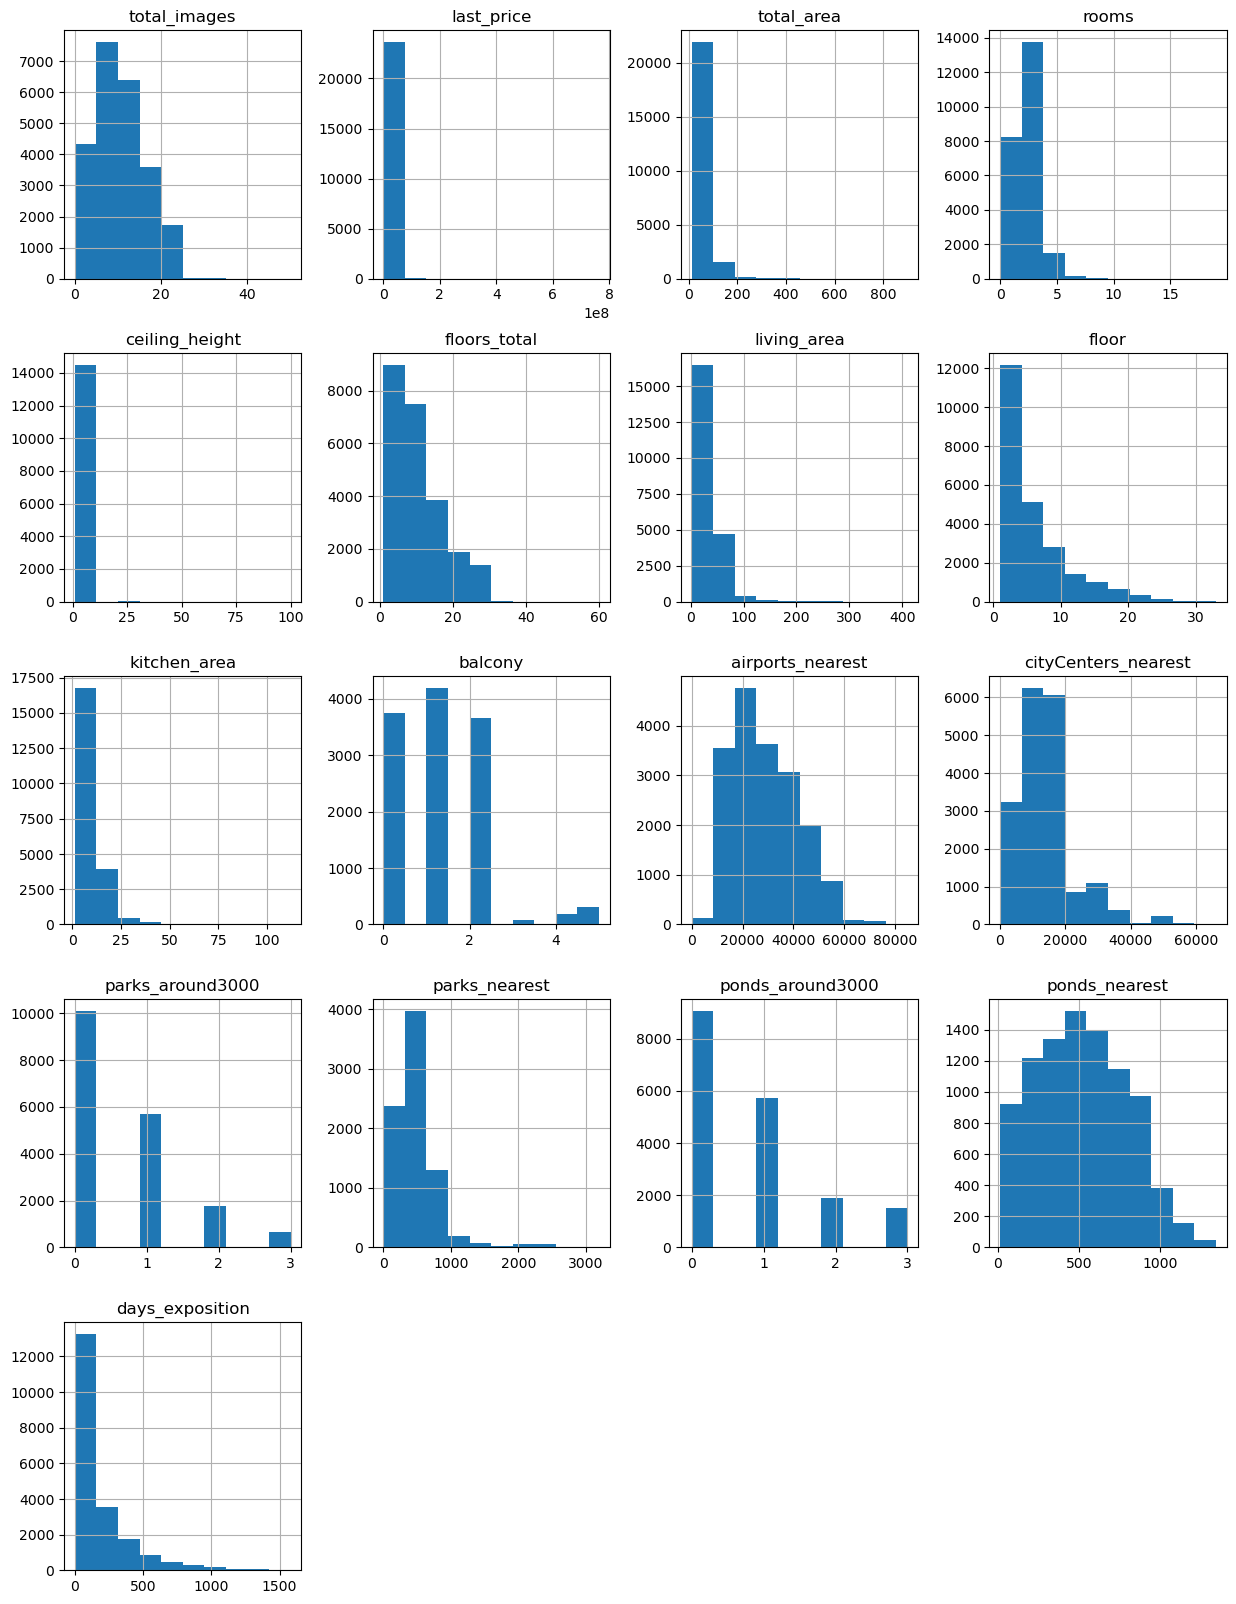

In [142]:
data.hist(figsize=(15, 20));

In [143]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Обнаружено множество пропусков и неверных типов столбцов

### Предобработка данных

Найдем процент пустых значений для каждого неполного столбца

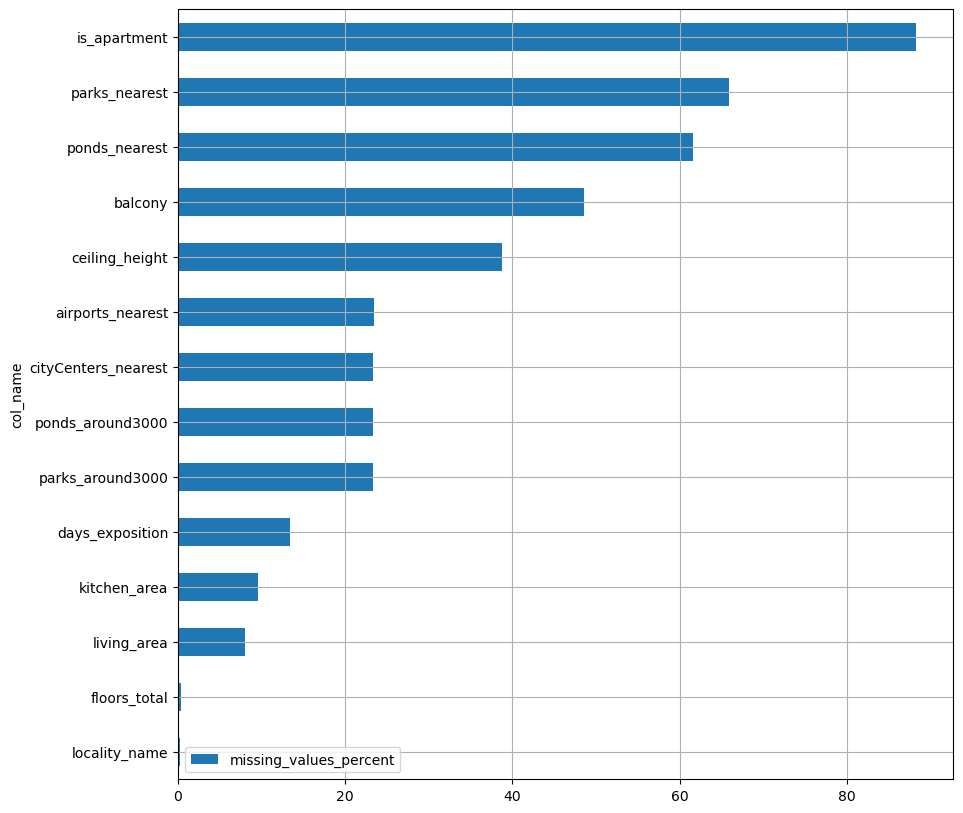

In [144]:
null_data_stat = pd.DataFrame({'col_name':[],'missing_values_percent':[]})
for col in data:
    if data[col].isna().sum()!=0:
        null_data_stat.loc[len(null_data_stat)]= [col,(data[col].isna().sum()/data.shape[0])*100]

null_data_stat.pivot_table(index='col_name',values='missing_values_percent')\
.sort_values(by='missing_values_percent')\
.plot(kind='barh', grid=True, figsize=(10, 10));

В столбце *is_apartment* отсутствует более 88% значений
Это данные содержащие False - 2725 значений,  True - 50 значений.

В *ponds_nearest* и *parks_nearest* не указаны более 60% значений, *balcony* и *ceiling_height* - 48%, 38%.

Количество отсутствующих значений: *airports_nearest* - 5542, *cityCenters_nearest* - 5519, *ponds_around3000* - 5518, *parks_around3000* - 5518. Разница невелика, возможно пропуски в этих столбцах связаны между собой

*days_exposition*, *kitchen_area*, *living_area* недостает 13.4%, 9.6%, 8% значений.

Почти отсутствуют пропуски в *floors_total*(86) и *locality_name*(49)

In [145]:
data.isna().mean()*100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
cityCenters_nearest     23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

#### **Обработка пропусков**

Отсутствие значений в ponds_around3000, parks_around3000 и balcony скорее всего означает, что поблизости нет ни парков, ни водоемов, и балконов в помещении нет. Тем более что значений 0 среди этих столбцов не встречается. Но столбцы airports_nearest и cityCenters_nearest имеют пропуски в тех же значениях что и колонки ponds_around3000 и parks_around3000. Это может значить, что данные были повреждены/удалены.

Заменим пустые значения locality_name на '-'

Остальные столбцы не будем заменять средним или медианным значением, т.к. мы не можем знать наверняка площадь, количество этажей, расстояние до центра и т.д.

In [146]:
data_null= data[data['airports_nearest'].isna()]
data_null= data_null[data_null['cityCenters_nearest'].isna()]
data_null= data_null[data_null['ponds_around3000'].isna()]
data_null= data_null[data_null['parks_around3000'].isna()]
data_null.shape[0] 

5518

In [147]:
data['balcony']= data['balcony'].fillna(0)
data['ponds_around3000']= data['ponds_around3000'].fillna(0)
data['parks_around3000']= data['parks_around3000'].fillna(0)
data['locality_name']= data['locality_name'].fillna('-')

Удалим столбец 'is_apartment'

In [148]:
data = data.drop(columns='is_apartment')

#### **Типы данных** <a id='2'></a>

first_day_exposition - содержит информацию о дате и времени: object>datetime

balcony - значения могут быть только целыми: float>int

is_apartment, balcony, parks_around3000, ponds_around3000, days_exposition - содержат NaN и не могут быть преобразованы в тип int

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   studio                23699 non-null  bool   
 10  open_plan             23699 non-null  bool   
 11  kitchen_area          21421 non-null  float64
 12  balcony               23699 non-null  float64
 13  locality_name         23699 non-null  object 
 14  airports_nearest      18157 non-null  float64
 15  cityCenters_nearest

In [150]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['balcony']= data['balcony'].astype('int')
data = data.dropna(subset=['floors_total'])
data['floors_total'] = data['floors_total'].astype('int')

#### **Неявные дубликаты**

In [151]:
data['locality_name'].value_counts().count()

365

In [152]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')

In [153]:
data['locality_name'].sort_values().unique()

array(['-', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской посело

In [154]:
def locality_name_changer(locality_name):
    if 'садоводческое некоммерческое товарищество' in locality_name: return locality_name[42:]
    elif 'садовое товарищество' in locality_name: return locality_name[21:]
    elif 'поселок при железнодорожной станции' in locality_name: return locality_name[36:]
    elif 'поселок станции' in locality_name: return locality_name[16:]
    elif 'коттеджный поселок' in locality_name: return locality_name[19:]
    elif 'поселок городского типа имени' in locality_name: return locality_name[30:]
    elif 'поселок городского типа' in locality_name: return locality_name[24:]
    elif 'городской поселок' in locality_name: return locality_name[18:]
    elif 'поселок' in locality_name: return locality_name[8:]
    elif 'село' in locality_name: return locality_name[5:]
    elif 'деревня' in locality_name: return locality_name[8:]
    else: return locality_name

In [155]:
data['locality_name'] = data['locality_name'].apply(locality_name_changer)

In [156]:
data['locality_name'].value_counts().count()

306

In [157]:
# check
data.locality_name.nunique()

306

In [158]:
# check
data.locality_name.unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [159]:
data.duplicated(subset=['total_area','floor','floors_total','cityCenters_nearest','locality_name','rooms']).sum()

210

In [160]:
data = data.drop_duplicates(subset=['total_area','floor','floors_total','cityCenters_nearest','locality_name','rooms'], keep='first')

#### **Аномалии** <a id='1'></a>

In [161]:
# потолки выше 25 метров скорее всего указаны в дециметрах
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<25,data['ceiling_height']/10)

Избавимся от редких и выбивающихся значений 

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23403 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23403 non-null  int64         
 1   last_price            23403 non-null  float64       
 2   total_area            23403 non-null  float64       
 3   first_day_exposition  23403 non-null  datetime64[ns]
 4   rooms                 23403 non-null  int64         
 5   ceiling_height        14384 non-null  float64       
 6   floors_total          23403 non-null  int32         
 7   living_area           21561 non-null  float64       
 8   floor                 23403 non-null  int64         
 9   studio                23403 non-null  bool          
 10  open_plan             23403 non-null  bool          
 11  kitchen_area          21200 non-null  float64       
 12  balcony               23403 non-null  int32         
 13  locality_name   

In [163]:
data = data.query('last_price.isna() or (last_price>500000 and last_price<50000000)')
data = data.query('total_images.isna() or total_images<25')
data = data.query('total_area.isna() or (total_area<250 and total_area>20)')
data = data.query('rooms.isna() or rooms<7')
data = data.query('floors_total.isna() or floors_total<30')
data = data.query('living_area.isna() or (living_area<150 and living_area>10)')
data = data.query('kitchen_area.isna() or (kitchen_area<50 and kitchen_area>4.5)')
data = data.query('ceiling_height.isna() or (ceiling_height>=2.5 and ceiling_height<5)')
data = data.query('days_exposition.isna() or (days_exposition>3 and days_exposition<1300)')

In [164]:
data.floor.mean()

5.892440965656744

In [165]:
data.floor.isna().sum()

0

In [166]:
data.shape[0]

22741

От исходного датасета осталось 95.96%

### Добавление новых столбцов

Цена одного квадратного метра

In [167]:
data['cubic_meter_price']=data['last_price']/data['total_area']

День недели публикации объявления

In [168]:
data['exposition_dow']=data['first_day_exposition'].dt.dayofweek

Месяц публикации объявления

In [169]:
data['exposition_month']=data['first_day_exposition'].dt.month

Год публикации объявления

In [170]:
data['exposition_year']=data['first_day_exposition'].dt.year

Тип этажа квартиры

In [171]:
def floor_type_maker(row):
    max_floor=row['floors_total']
    curr_floor=row['floor']
    if curr_floor==1:
        return 'Первый'
    elif max_floor==curr_floor: return 'Последний'
    else: return 'Другой'
data['floor_type'] = data.apply(floor_type_maker, axis=1)
data['floor_type'] = data['floor_type'].astype('category')

def floor_type_int_maker(row): #
    max_floor=row['floors_total']
    curr_floor=row['floor']
    if curr_floor==1:
        return 1
    elif max_floor==curr_floor: return 2
    else: return 0
data['floor_type_int'] = data.apply(floor_type_int_maker, axis=1)

Расстояние до центра города в километрах

In [172]:
data['city_center_km'] = (data['cityCenters_nearest']/1000).round(0)

### Исследовательский анализ данных

  - общая площадь ;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления

Столбец :  total_images
Среднее значение: 9.84


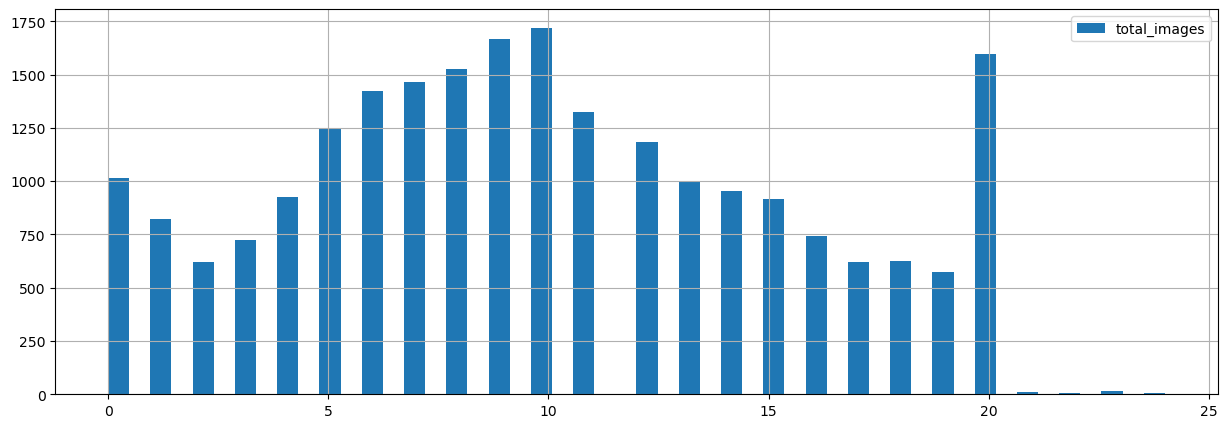

count    22741.000000
mean         9.841915
std          5.605691
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         24.000000
Name: total_images, dtype: float64
#################################################

Столбец :  last_price
Среднее значение: 5872930.35


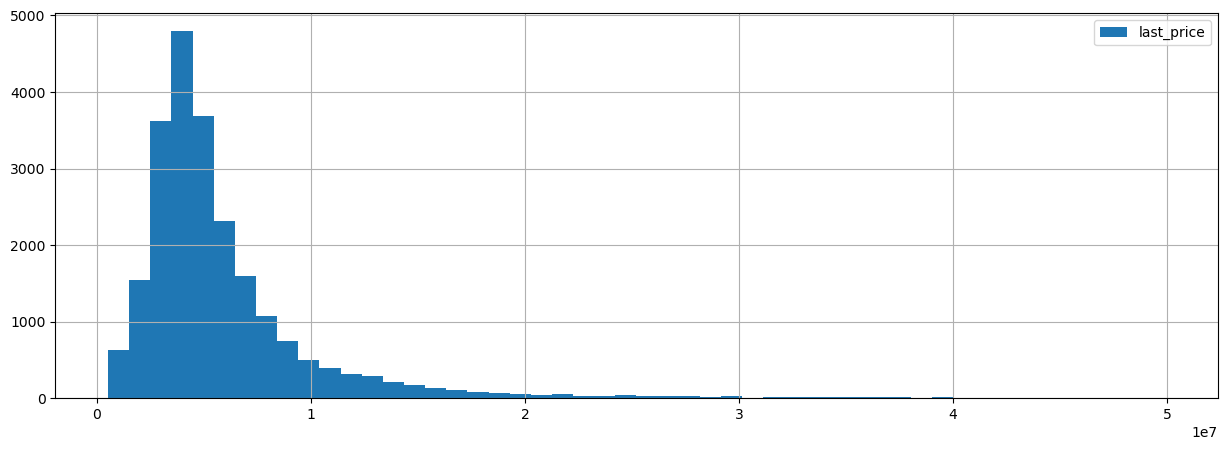

count    2.274100e+04
mean     5.872930e+06
std      4.570021e+06
min      5.200000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.690000e+06
max      4.990000e+07
Name: last_price, dtype: float64
#################################################

Столбец :  total_area
Среднее значение: 58.17


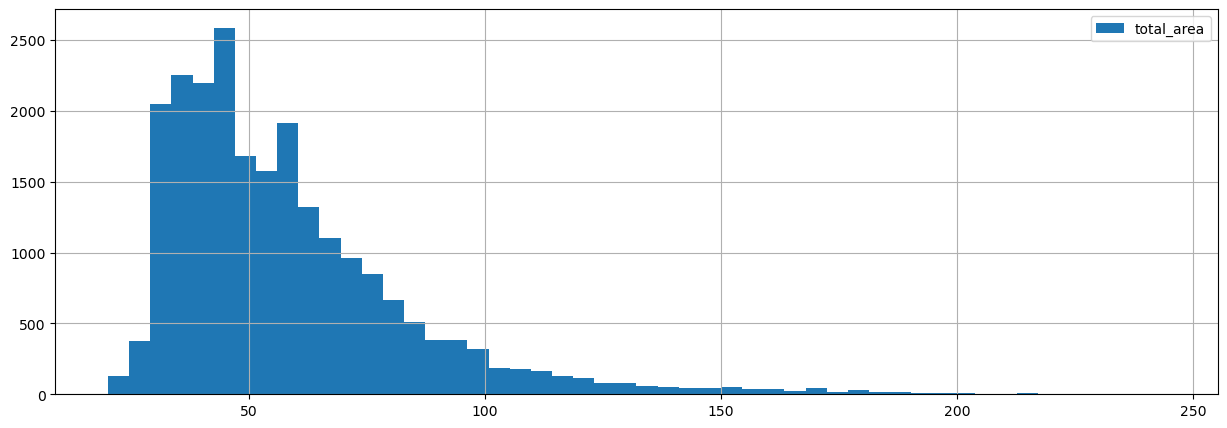

count    22741.000000
mean        58.172412
std         26.480821
min         20.100000
25%         40.000000
50%         52.000000
75%         68.700000
max        244.000000
Name: total_area, dtype: float64
#################################################

********Неподходящий тип данных в столбце first_day_exposition 

Столбец :  rooms
Среднее значение: 2.03


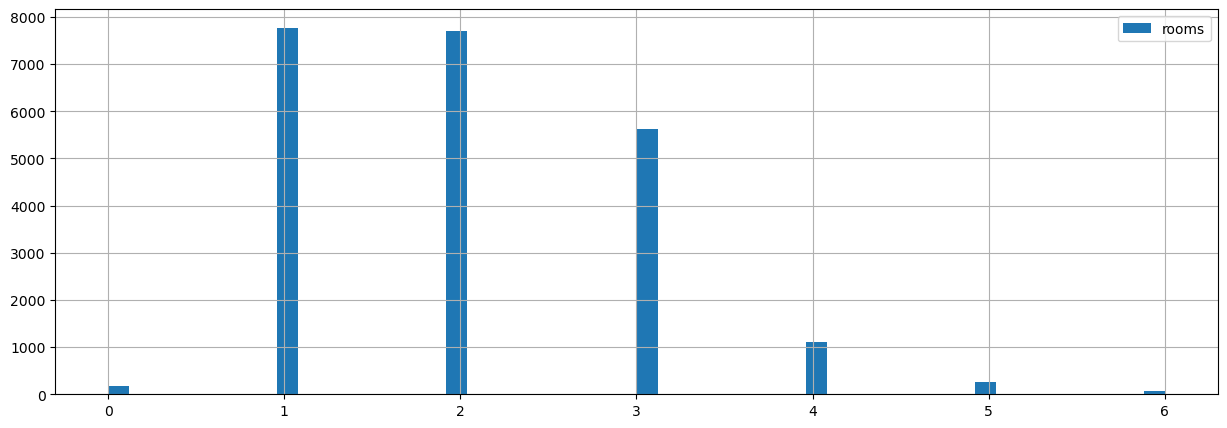

count    22741.000000
mean         2.034871
std          0.983759
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64
#################################################

Столбец :  ceiling_height
Среднее значение: 2.72


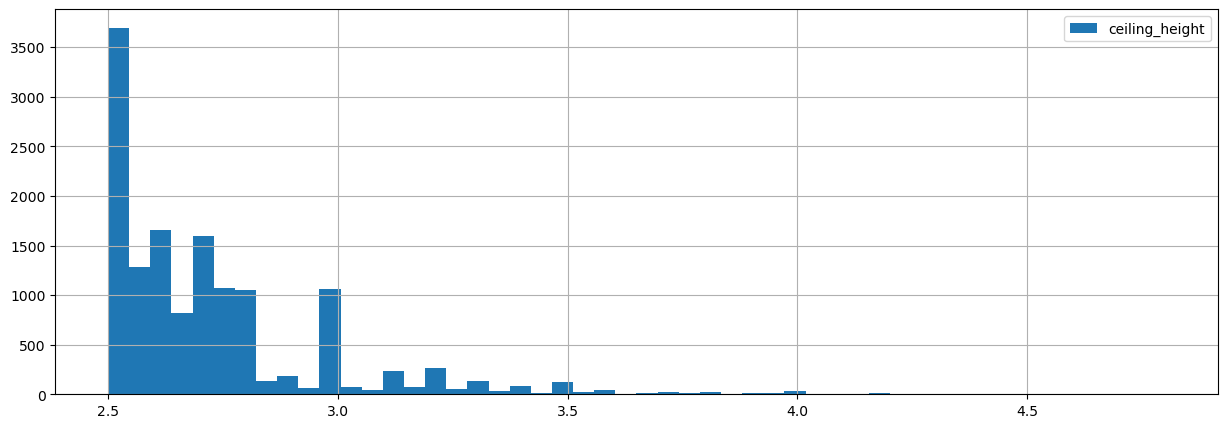

count    13954.000000
mean         2.719017
std          0.258697
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.800000
Name: ceiling_height, dtype: float64
#################################################

Столбец :  floors_total
Среднее значение: 10.73


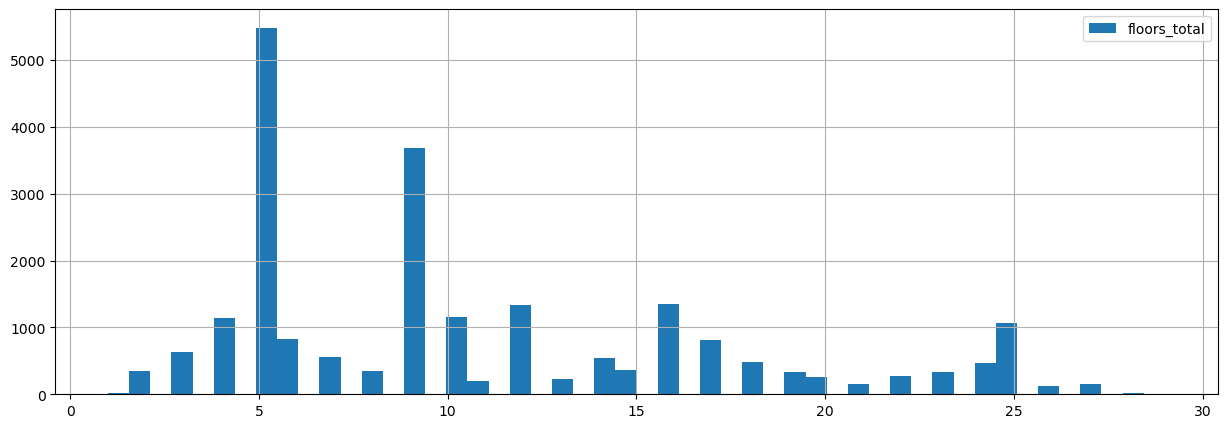

count    22741.000000
mean        10.733609
std          6.541284
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64
#################################################

Столбец :  living_area
Среднее значение: 33.23


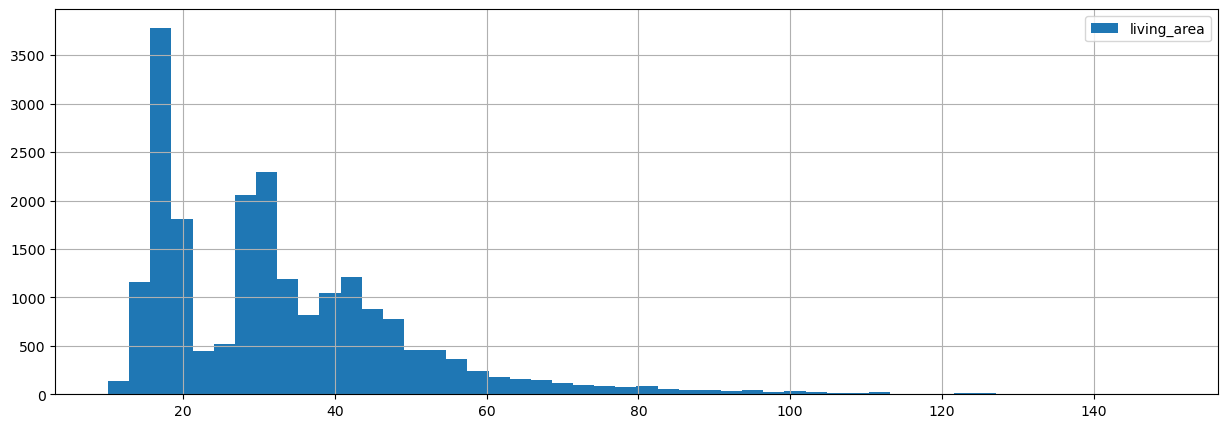

count    20960.000000
mean        33.234013
std         17.187782
min         10.080000
25%         18.600000
50%         30.000000
75%         42.000000
max        149.400000
Name: living_area, dtype: float64
#################################################

Столбец :  floor
Среднее значение: 5.89


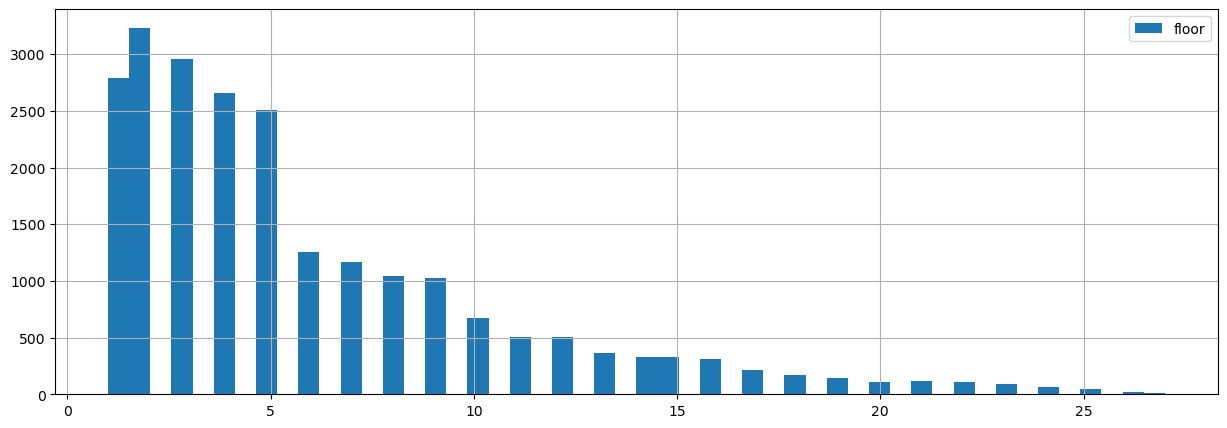

count    22741.000000
mean         5.892441
std          4.859300
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64
#################################################

********Неподходящий тип данных в столбце studio 

********Неподходящий тип данных в столбце open_plan 

Столбец :  kitchen_area
Среднее значение: 10.31


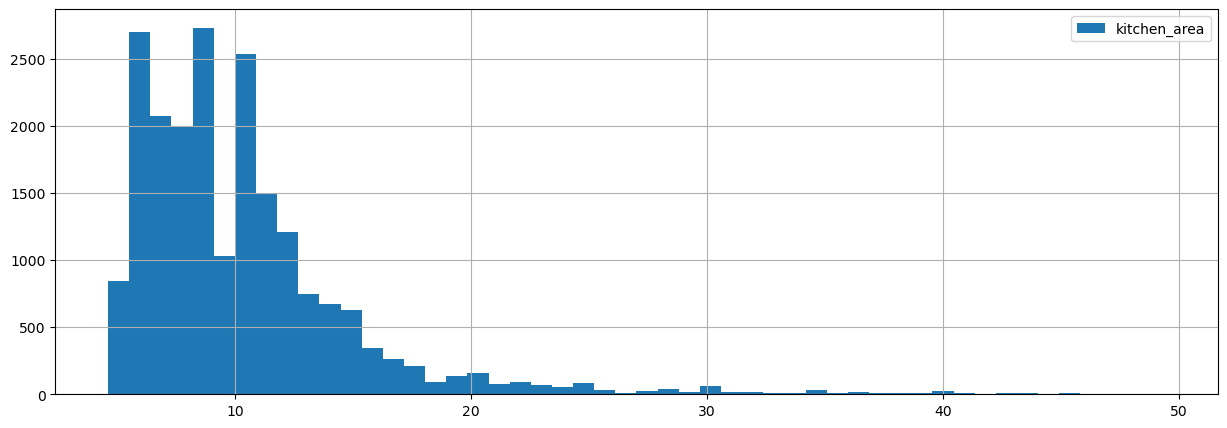

count    20632.000000
mean        10.307603
std          4.930996
min          4.600000
25%          7.000000
50%          9.000000
75%         11.900000
max         49.400000
Name: kitchen_area, dtype: float64
#################################################

Столбец :  balcony
Среднее значение: 0.60


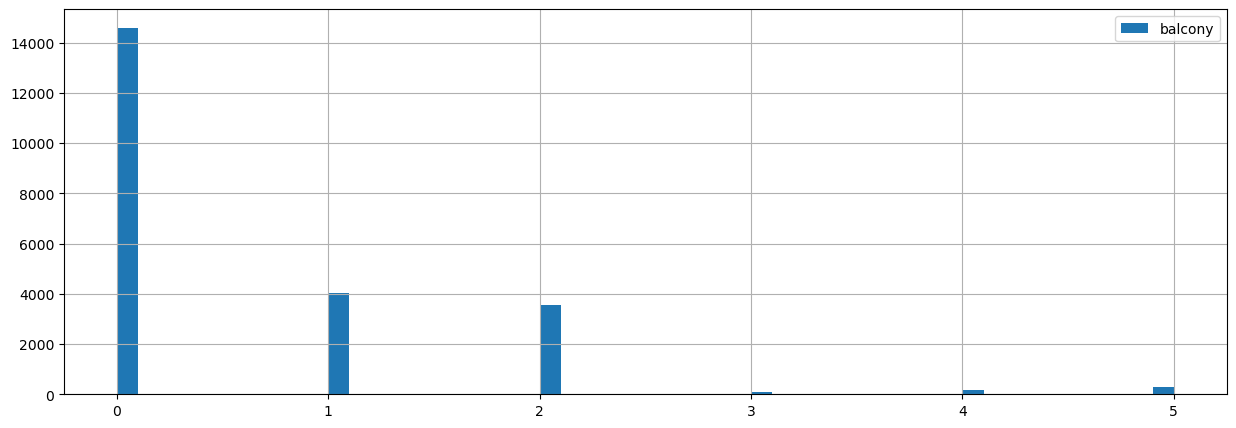

count    22741.000000
mean         0.595268
std          0.959305
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64
#################################################

********Неподходящий тип данных в столбце locality_name 

Столбец :  airports_nearest
Среднее значение: 28852.13


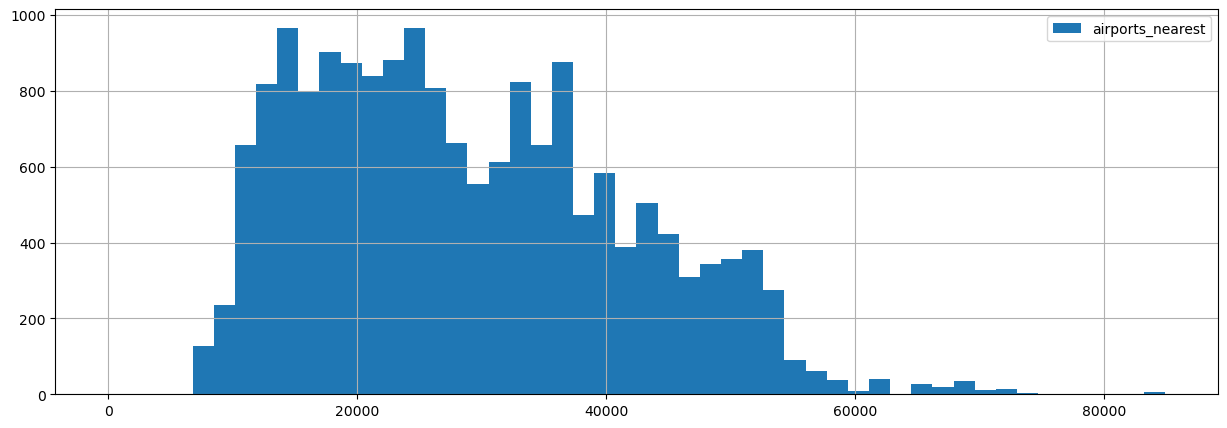

count    17463.000000
mean     28852.131650
std      12700.036697
min          0.000000
25%      18467.000000
50%      26885.000000
75%      37407.000000
max      84869.000000
Name: airports_nearest, dtype: float64
#################################################

Столбец :  cityCenters_nearest
Среднее значение: 14313.46


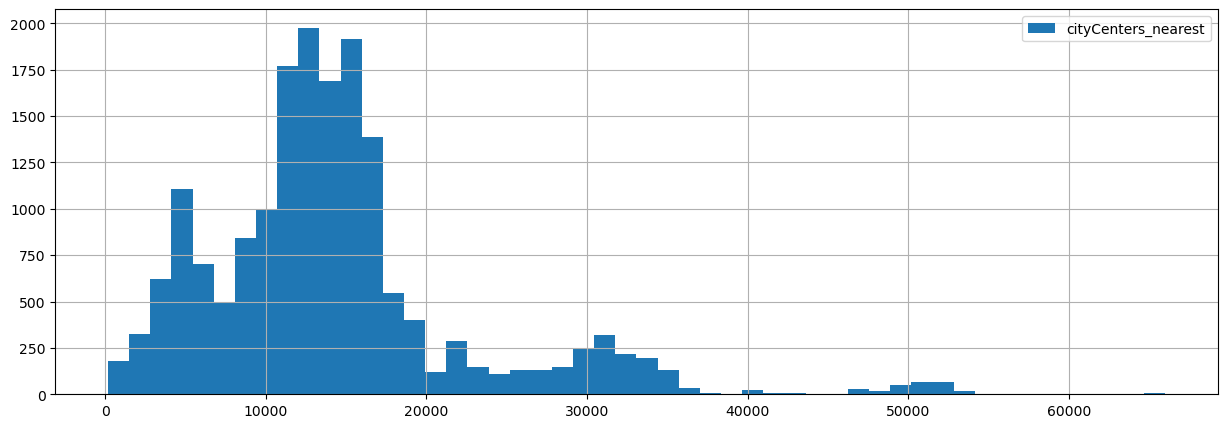

count    17483.000000
mean     14313.460790
std       8583.537797
min        181.000000
25%       9496.000000
50%      13168.000000
75%      16316.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
#################################################

Столбец :  parks_around3000
Среднее значение: 0.46


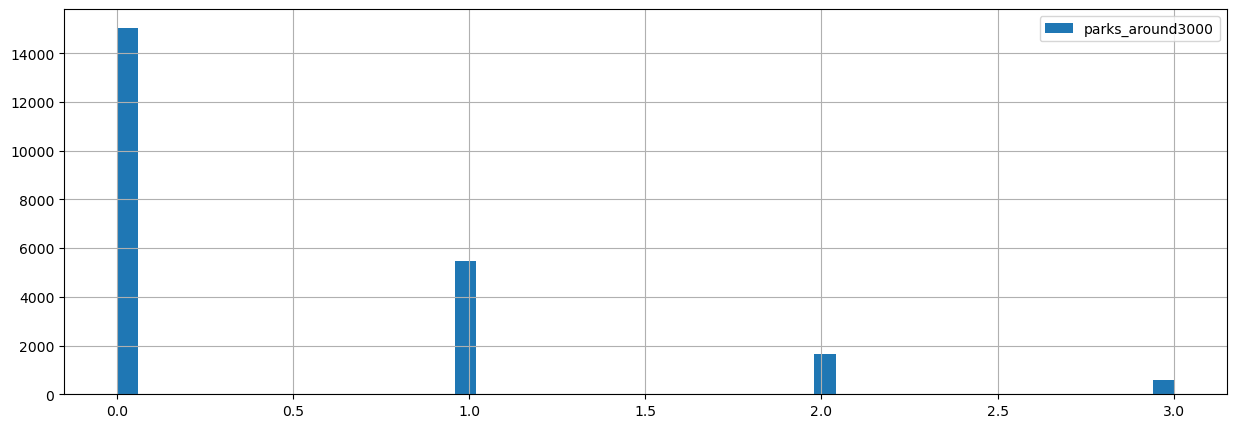

count    22741.000000
mean         0.460182
std          0.737284
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64
#################################################

Столбец :  parks_nearest
Среднее значение: 492.28


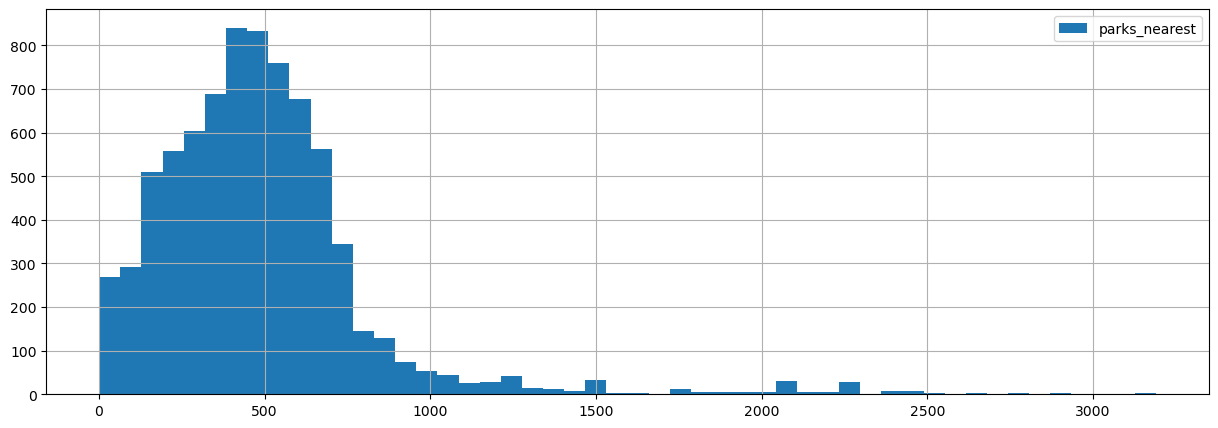

count    7687.000000
mean      492.283466
std       341.028554
min         1.000000
25%       288.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64
#################################################

Столбец :  ponds_around3000
Среднее значение: 0.58


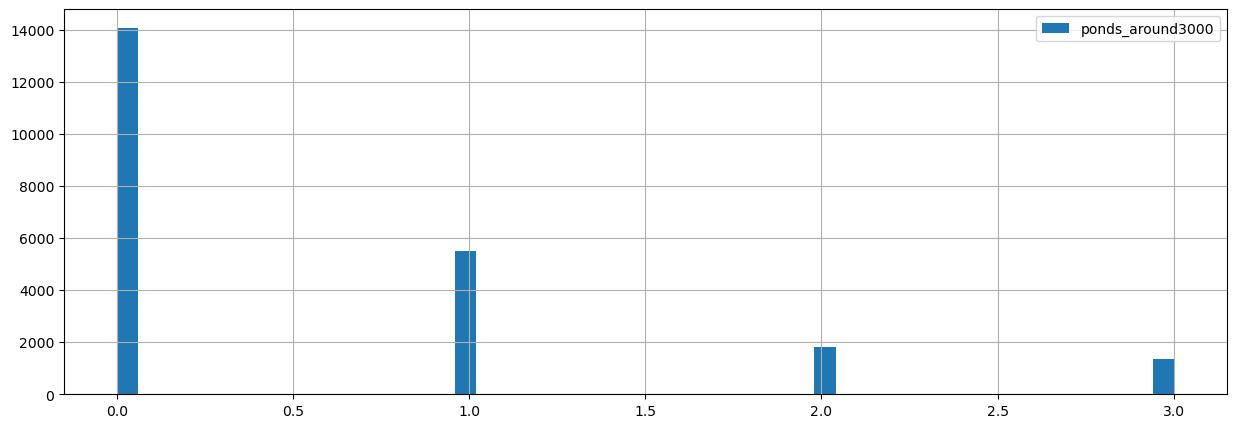

count    22741.000000
mean         0.579350
std          0.872326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64
#################################################

Столбец :  ponds_nearest
Среднее значение: 523.68


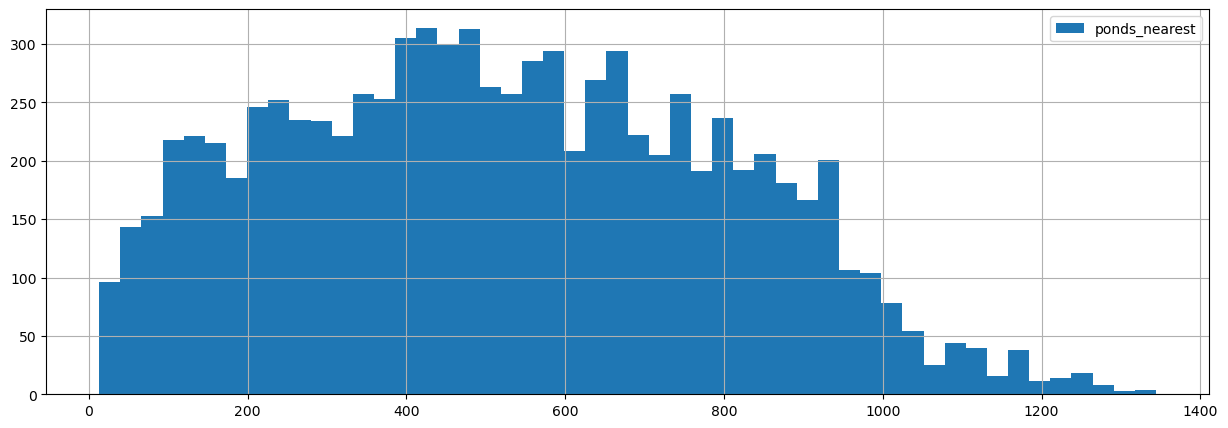

count    8652.000000
mean      523.681114
std       276.840504
min        13.000000
25%       303.000000
50%       509.000000
75%       733.000000
max      1344.000000
Name: ponds_nearest, dtype: float64
#################################################

Столбец :  days_exposition
Среднее значение: 176.85


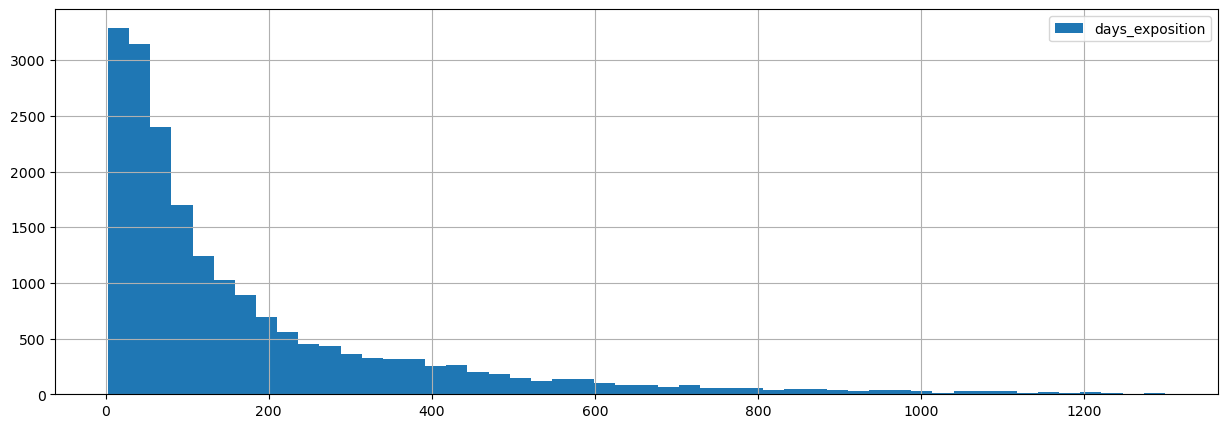

count    19711.000000
mean       176.846127
std        210.344886
min          3.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1299.000000
Name: days_exposition, dtype: float64
#################################################

Столбец :  cubic_meter_price
Среднее значение: 97512.11


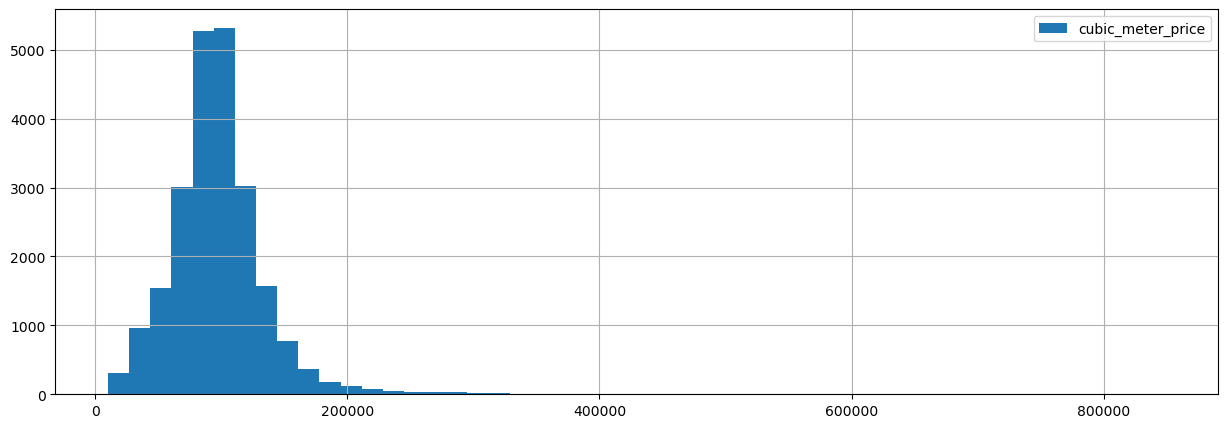

count     22741.000000
mean      97512.105740
std       38780.137767
min       10185.185185
25%       76744.186047
50%       94857.142857
75%      113571.428571
max      848484.848485
Name: cubic_meter_price, dtype: float64
#################################################

Столбец :  exposition_dow
Среднее значение: 2.57


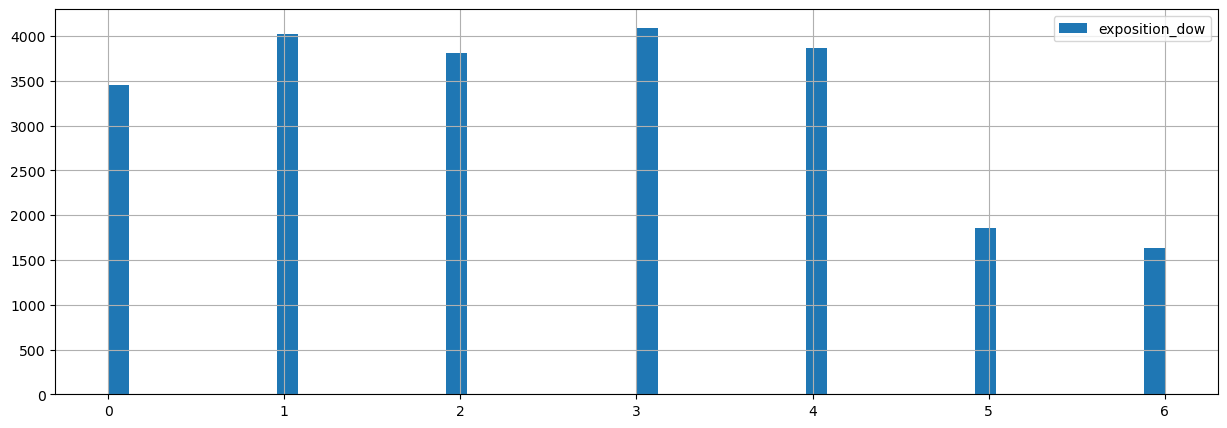

count    22741.000000
mean         2.571567
std          1.789085
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_dow, dtype: float64
#################################################

Столбец :  exposition_month
Среднее значение: 6.40


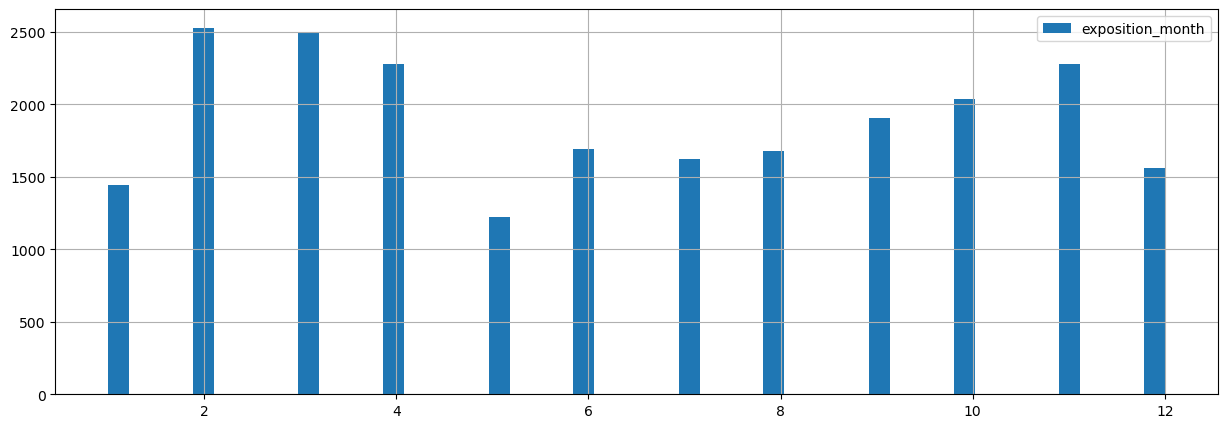

count    22741.000000
mean         6.397080
std          3.489779
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64
#################################################

Столбец :  exposition_year
Среднее значение: 2017.38


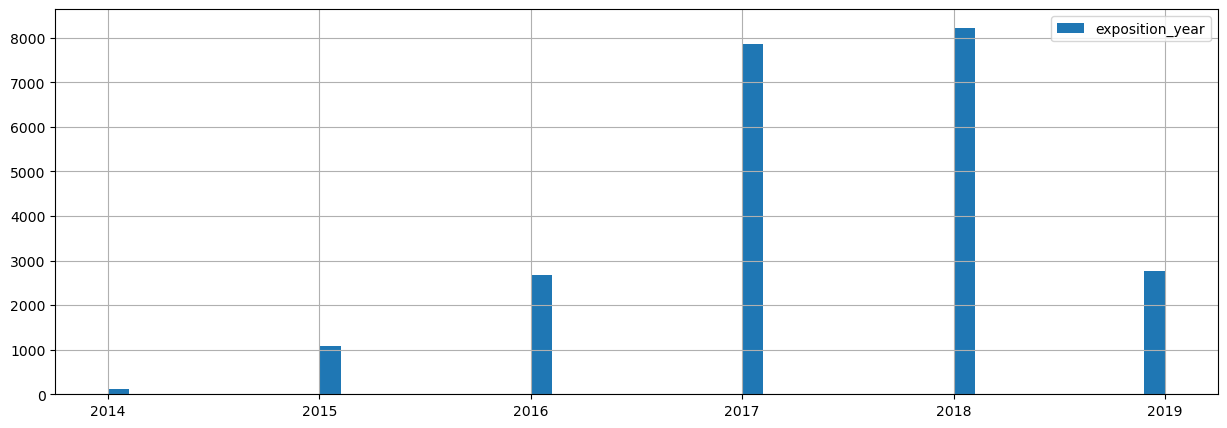

count    22741.000000
mean      2017.377160
std          1.030496
min       2014.000000
25%       2017.000000
50%       2017.000000
75%       2018.000000
max       2019.000000
Name: exposition_year, dtype: float64
#################################################

********Неподходящий тип данных в столбце floor_type 

Столбец :  floor_type_int
Среднее значение: 0.40


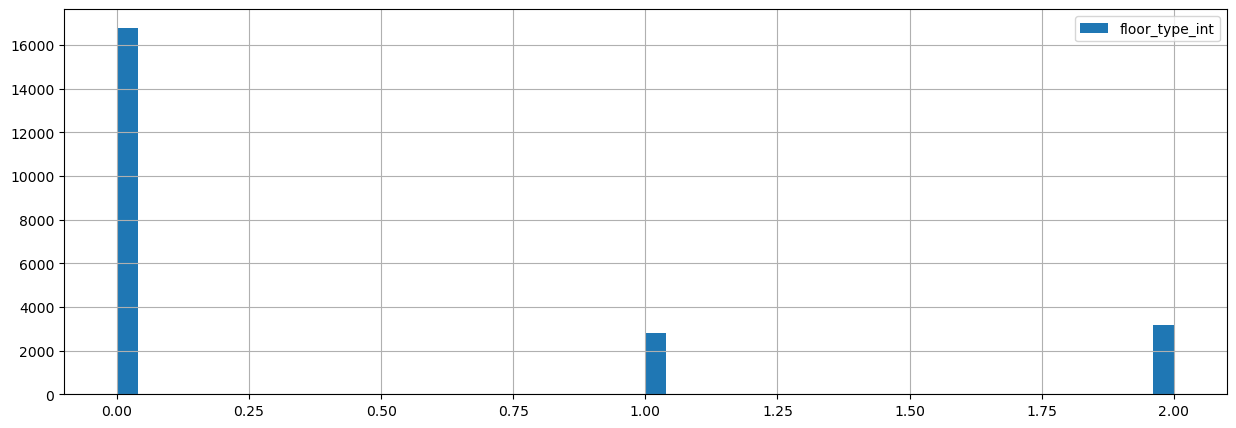

count    22741.000000
mean         0.400070
std          0.719381
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: floor_type_int, dtype: float64
#################################################

Столбец :  city_center_km
Среднее значение: 14.31


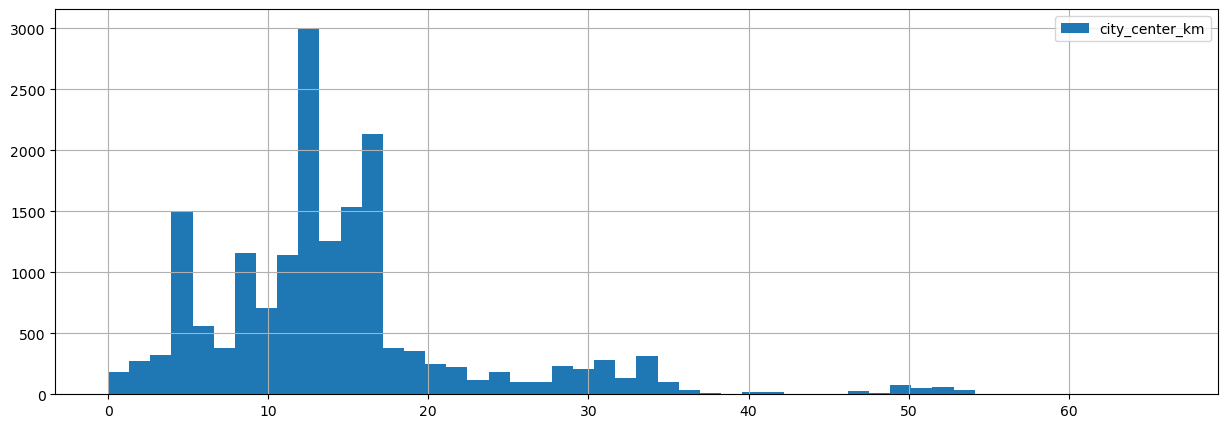

count    17483.000000
mean        14.307499
std          8.591895
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_center_km, dtype: float64
#################################################



In [173]:
for col in data:
    if data[col].dtype not in ['object','bool', 'datetime64[ns]', 'category']:
        print('Столбец : ', col)
        print('Среднее значение: ''%.2f' % data[col].mean())
        data[col].hist(bins=50,range=(data[col].min(), data[col].max()), figsize=(15,5), legend=True)
        plt.show()
        print(data[col].describe())
        print('#################################################\n')
    else: print('********Неподходящий тип данных в столбце', col, '\n')

#### Общий анализ объектов

**Общая площадь**

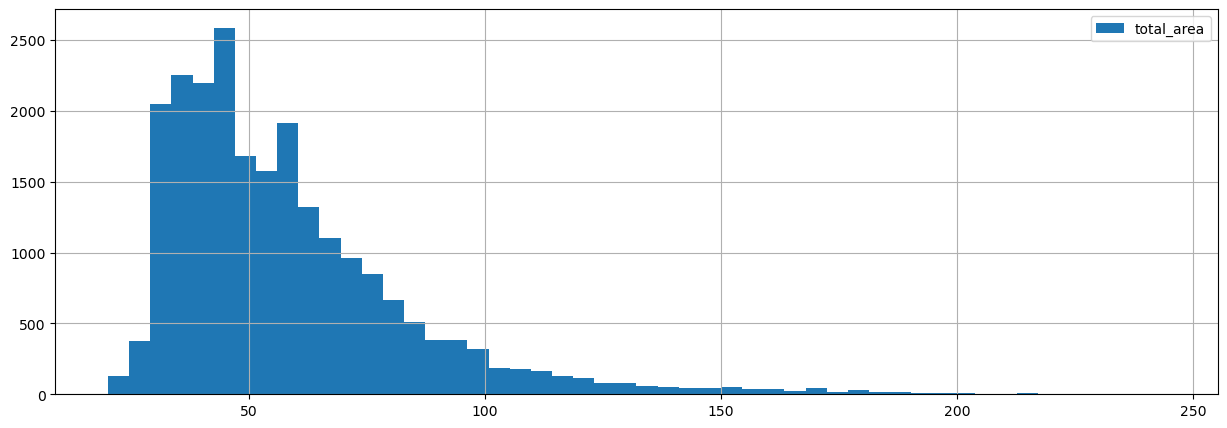

count    22741.000000
mean        58.172412
std         26.480821
min         20.100000
25%         40.000000
50%         52.000000
75%         68.700000
max        244.000000
Name: total_area, dtype: float64


In [174]:
data['total_area'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['total_area'].describe())

Большинство помещений имеют общую площадь от 25 до 70 кв. м.

Помещения общей площадью более 100кв.м. встречается редко

Максимальная общая площадь помещения - 244кв.м.

**Жилая площадь**

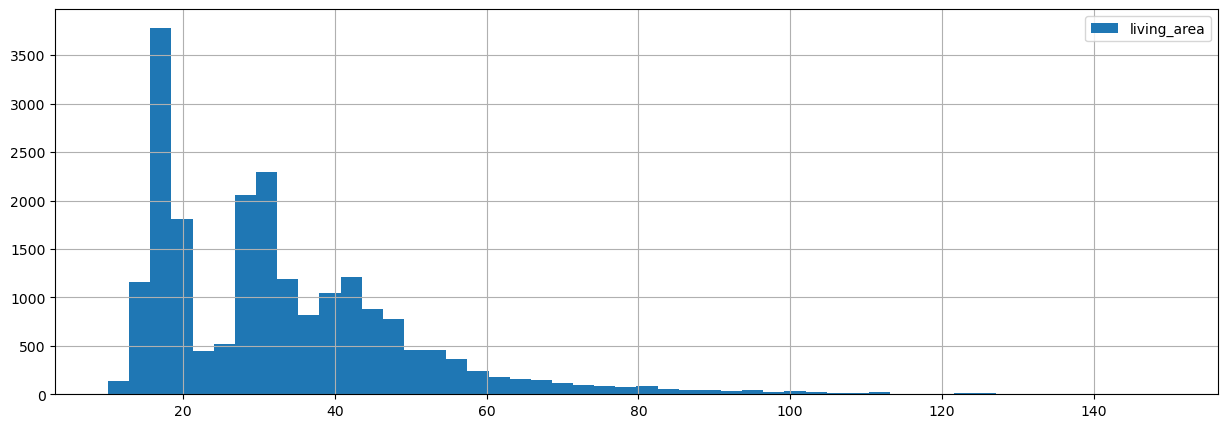

count    20960.000000
mean        33.234013
std         17.187782
min         10.080000
25%         18.600000
50%         30.000000
75%         42.000000
max        149.400000
Name: living_area, dtype: float64


In [175]:
data['living_area'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['living_area'].describe())

Большинство помещений имеют жилую площадь от 14 до 21 кв. м. и 27 - 48 кв. м.



Помещения с жилой площадью более 60кв.м. встречается редко

Максимальная жилая площадь помещения - 149кв.м.

**Площадь кухни**

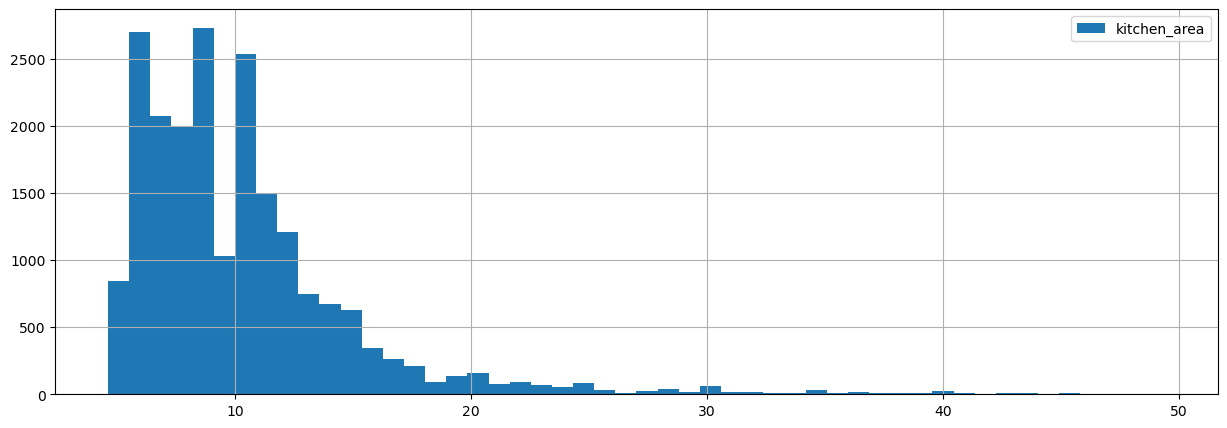

count    20632.000000
mean        10.307603
std          4.930996
min          4.600000
25%          7.000000
50%          9.000000
75%         11.900000
max         49.400000
Name: kitchen_area, dtype: float64


In [176]:
data['kitchen_area'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['kitchen_area'].describe())

Большинство помещений имеют площадь кухни от 5 до 13 кв. м.

Помещения с площадью кухни более 18 кв.м. встречается редко

Максимальная площадь кухни - 49кв.м

**Цена объекта**

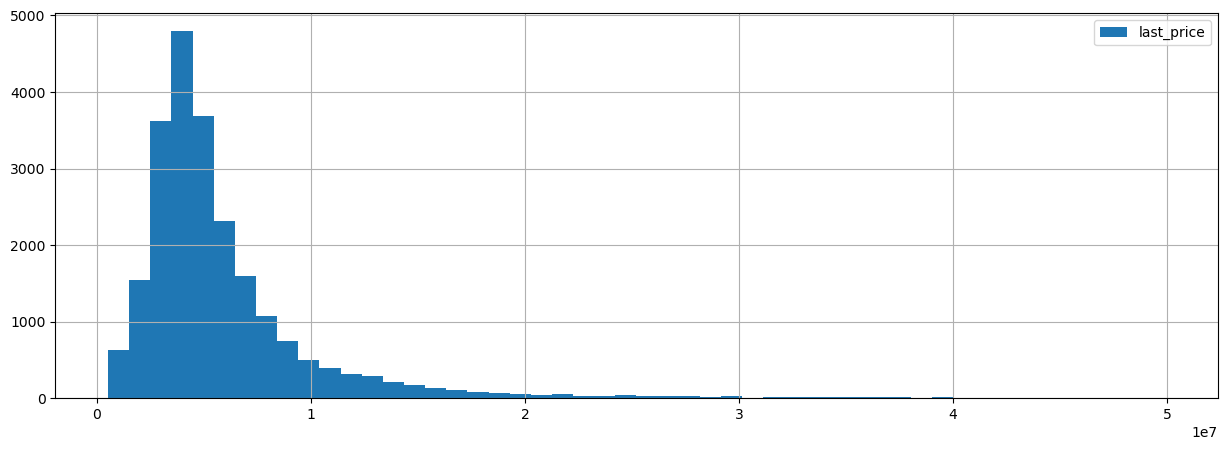

count    2.274100e+04
mean     5.872930e+06
std      4.570021e+06
min      5.200000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.690000e+06
max      4.990000e+07
Name: last_price, dtype: float64


In [177]:
data['last_price'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['last_price'].describe())

Цены на помещения составляют от 1500 т.р. до 10 000 т.р. цены вне этого диапазона составляют 12.95% от всех цен.

Более 80% значений составляют квартиры от 4 до 5 м.р.

**Количество комнат**

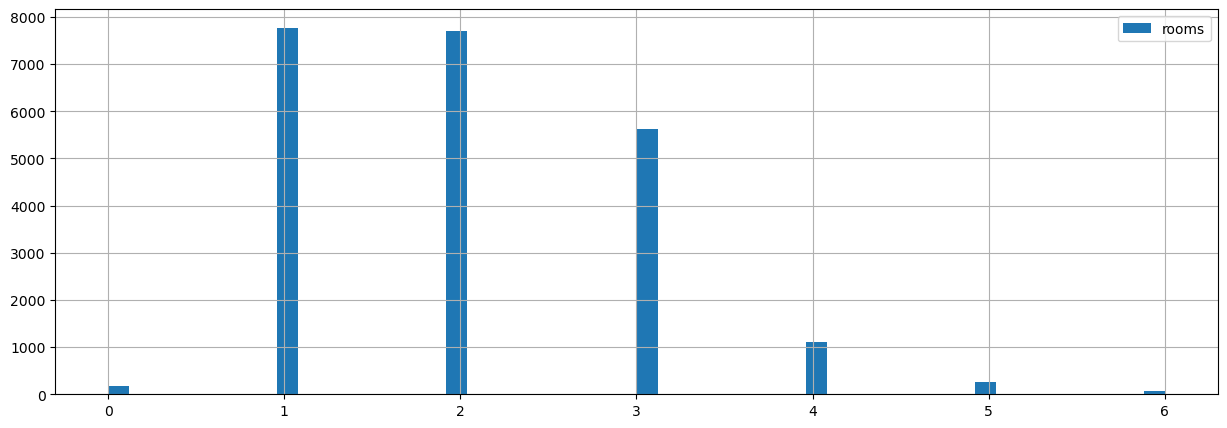

count    22741.000000
mean         2.034871
std          0.983759
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64


In [178]:
data['rooms'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['rooms'].describe())

Встречаются помещения без комнат - это могут быть студии или нежилые помещения

Квартиры с числом комнат больше 3 встречаются редко

**Высота потолков**

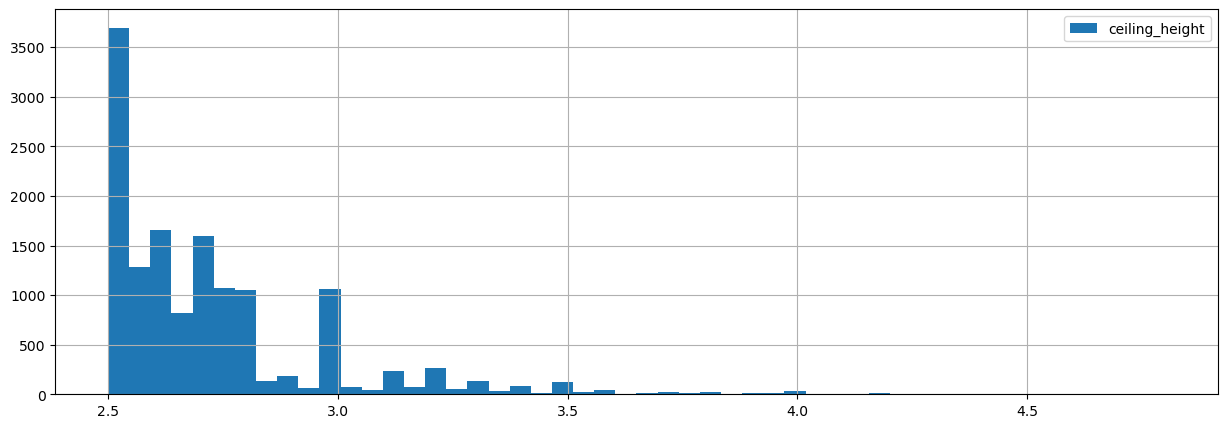

count    13954.000000
mean         2.719017
std          0.258697
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.800000
Name: ceiling_height, dtype: float64


In [179]:
data['ceiling_height'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['ceiling_height'].describe())

В большинстве случаев высота потолка варьируется от 2.5 до 3 метров. Встчеются и выше, но редко 

**Этаж квартиры**

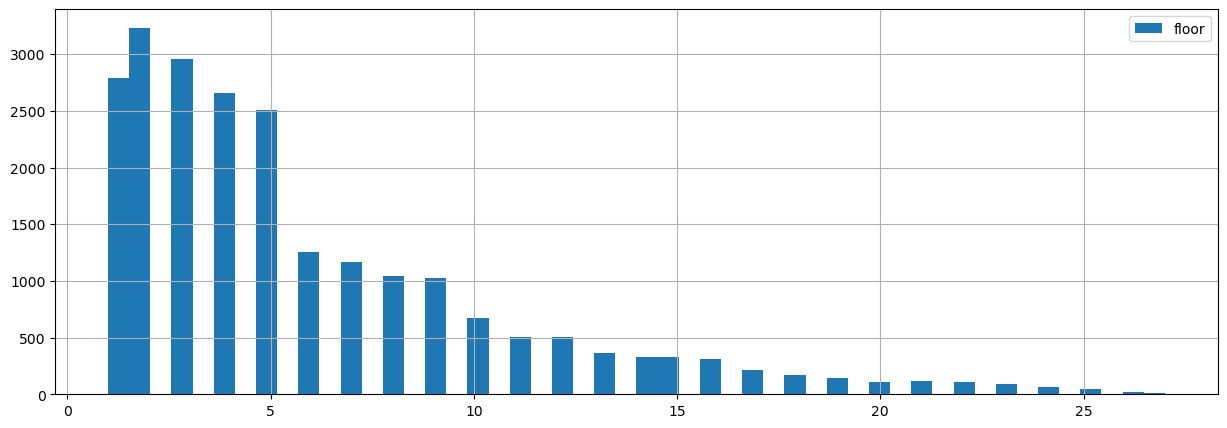

count    22741.000000
mean         5.892441
std          4.859300
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64


In [180]:
data['floor'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['floor'].describe())

Больше всего квартир расположены на 1-5 этажах, возможно из=за количества домов 5-этажных домов в датасете.

Похожая ситуация до 10 этажа - график после этих значений 5 и 10 снижается резко.

**Тип этажа квартиры**

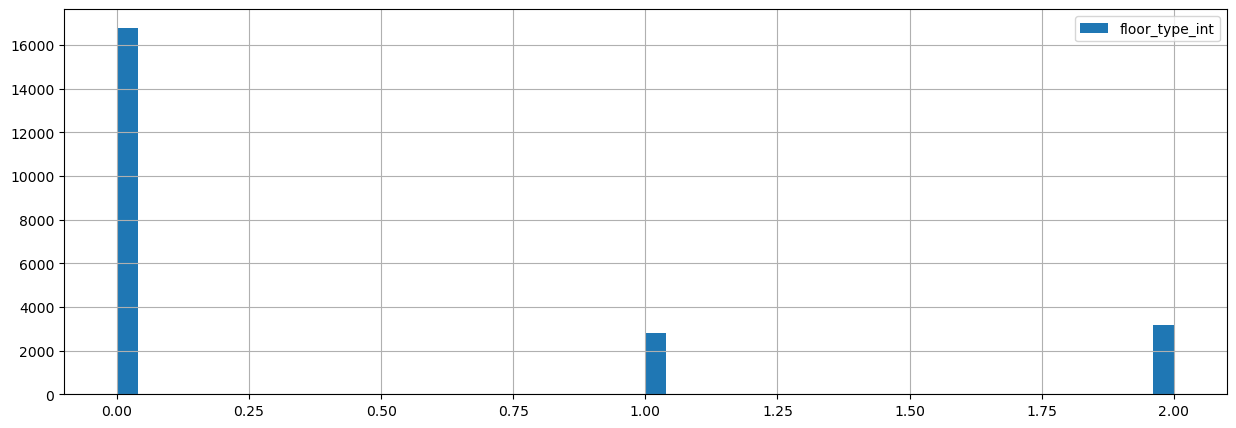

count    22741.000000
mean         0.400070
std          0.719381
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: floor_type_int, dtype: float64


In [181]:
data['floor_type_int'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['floor_type_int'].describe())

Ожидаемо число квартир на крайних этажах меньше.

**Общее количество этажей в доме**

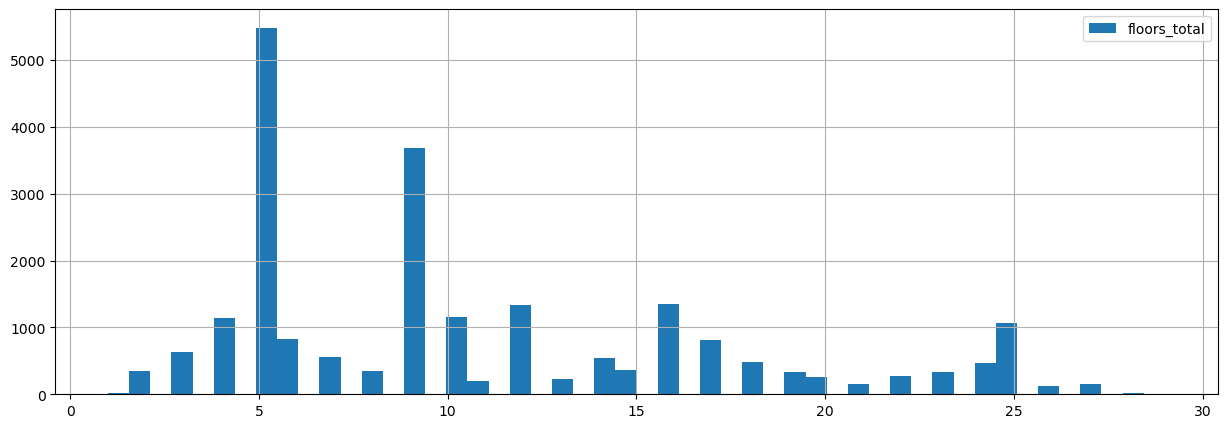

count    22741.000000
mean        10.733609
std          6.541284
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64


In [182]:
data['floors_total'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['floors_total'].describe())

Встечаются дома разной этажности, среди них можно выделить 5-и и 9-и этажные - их на порядок больше чем других

**Расстояние до центра города в метрах**

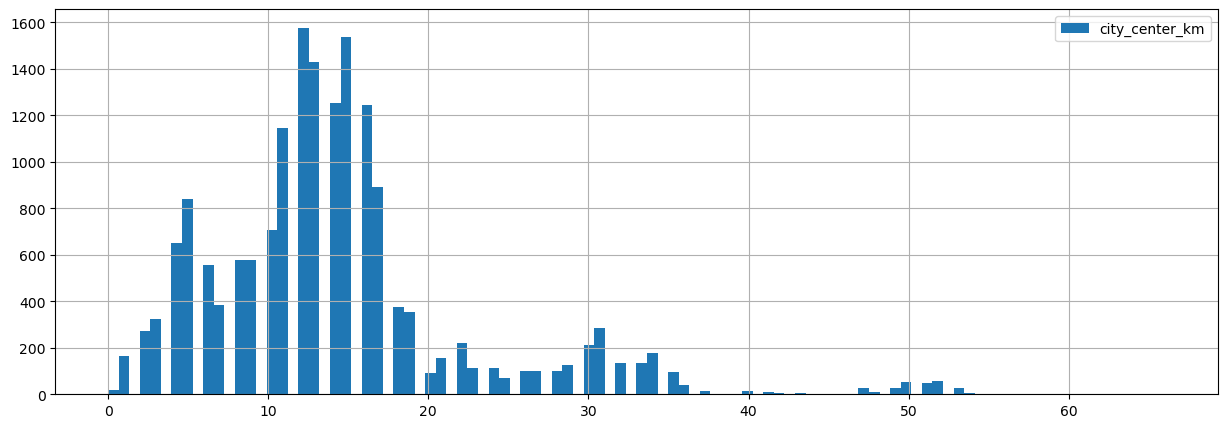

count    17483.000000
mean        14.307499
std          8.591895
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_center_km, dtype: float64


In [183]:
data['city_center_km'].hist(bins=100, figsize=(15,5), legend=True)
plt.show()
print(data['city_center_km'].describe())

Больше всего квартир продается на расстоянии от 4 до 17 км от центра.

**Расстояние до ближайшего аэропорта**

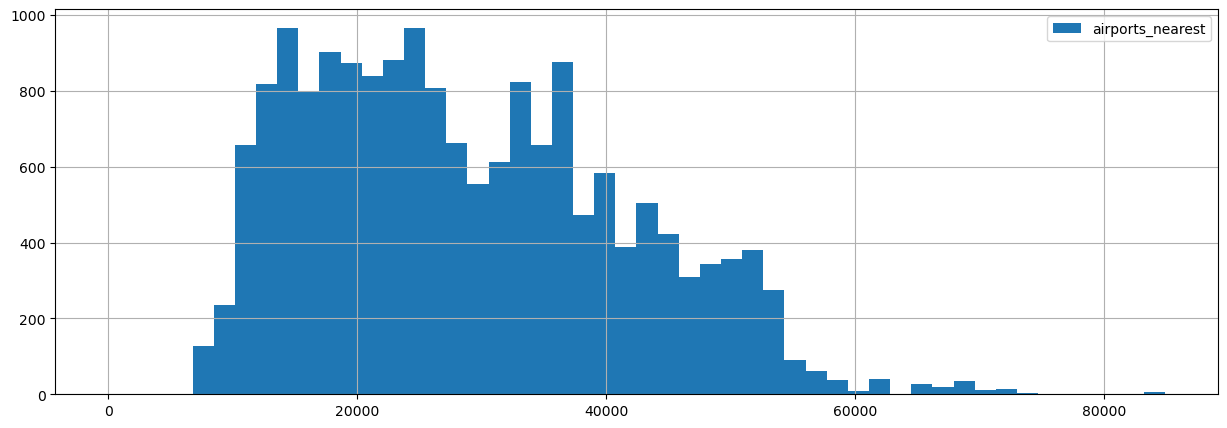

count    17463.000000
mean     28852.131650
std      12700.036697
min          0.000000
25%      18467.000000
50%      26885.000000
75%      37407.000000
max      84869.000000
Name: airports_nearest, dtype: float64


In [184]:
data['airports_nearest'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['airports_nearest'].describe())

Расстояние до аэропорта для большинства помещений составляет от 10 до 50км

**Расстояние до ближайшего парка**

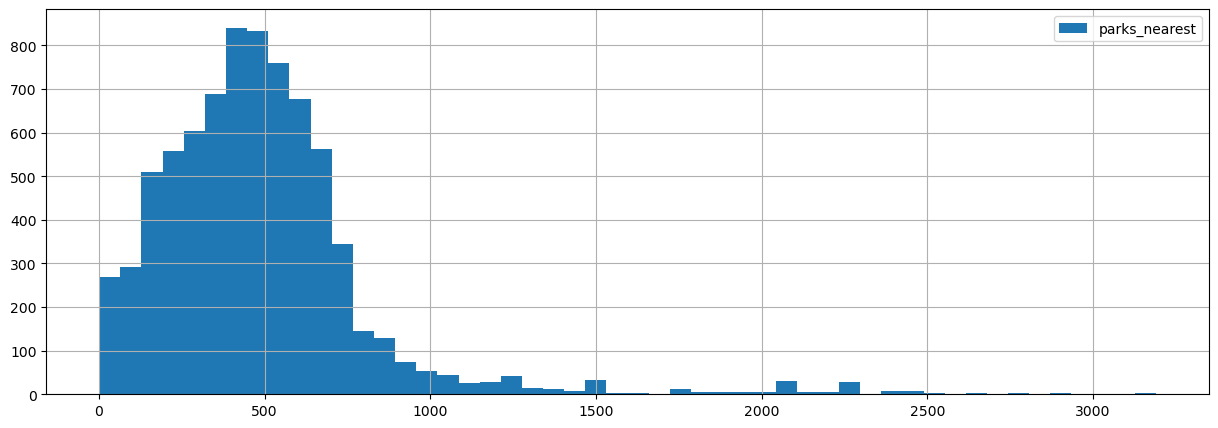

count    7687.000000
mean      492.283466
std       341.028554
min         1.000000
25%       288.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64


In [185]:
data['parks_nearest'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['parks_nearest'].describe())

Помещения где в пределах 750м нет парка встречаются редко

**День публикации объявления**

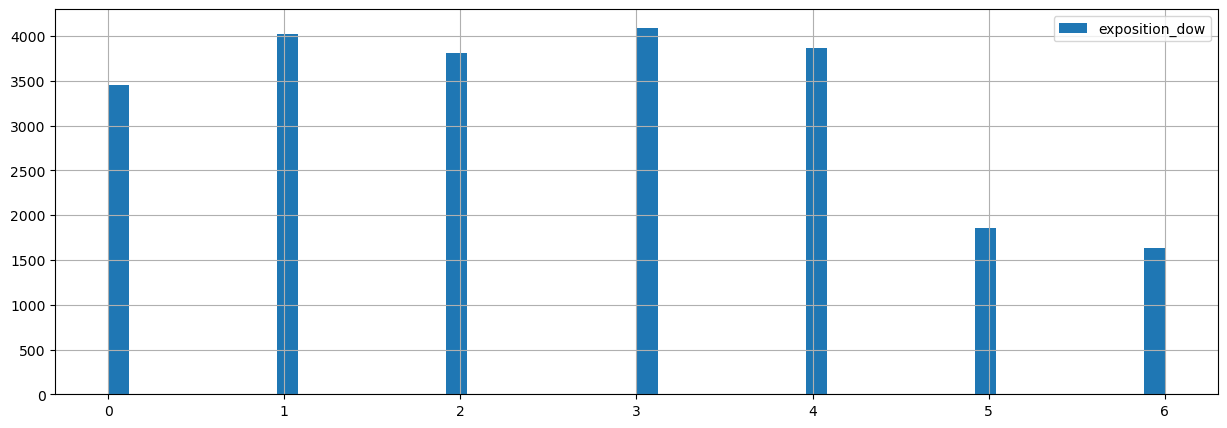

count    22741.000000
mean         2.571567
std          1.789085
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_dow, dtype: float64


In [186]:
data['exposition_dow'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['exposition_dow'].describe())

По выходным объявления выставляют реже чем по будням

**Месяц публикации объявления**

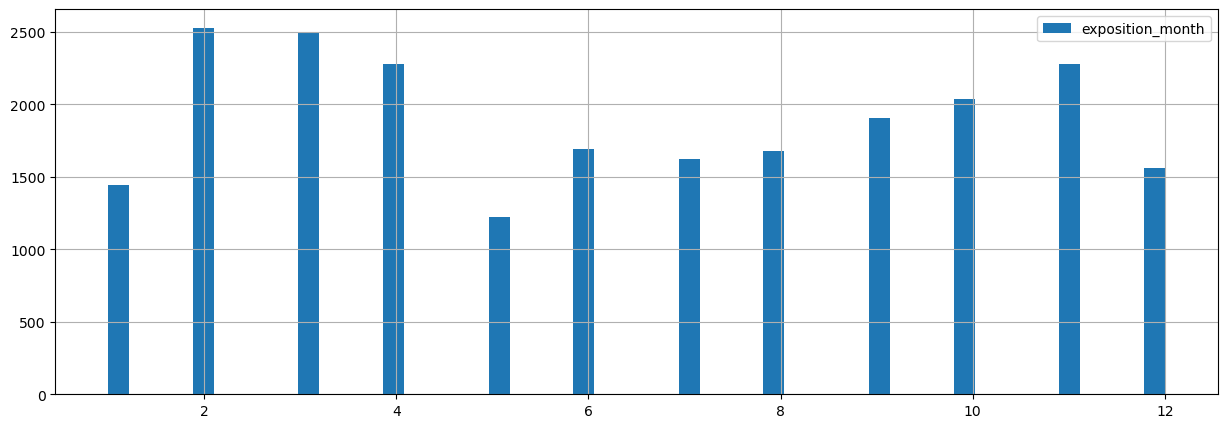

count    22741.000000
mean         6.397080
std          3.489779
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64


In [187]:
data['exposition_month'].hist(bins=50, figsize=(15,5), legend=True)
plt.show()
print(data['exposition_month'].describe())

В январе, мае и декабре объявления публикуются реже чем в остальные месяцы. Чаще всего их публикуют в феврале, марте, апреле и ноябре.

#### **Как быстро продавались квартиры**

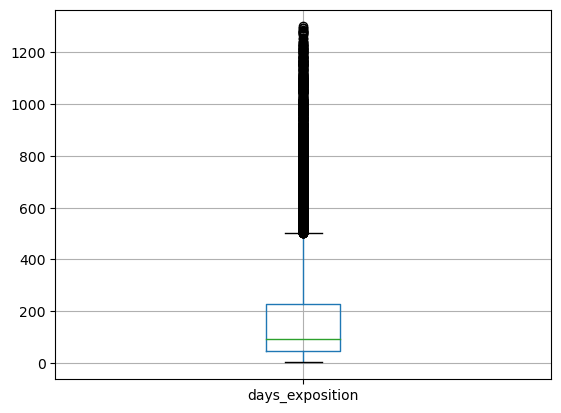

count    19711.000000
mean       176.846127
std        210.344886
min          3.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1299.000000
Name: days_exposition, dtype: float64

In [188]:
data.boxplot(column='days_exposition')
plt.show()
data['days_exposition'].describe()

Обычно продажа занимает приблизительно 95 дней.

Средняя скорость продажи составляет 177 дней

Объявления, снятые раньше 45 дней, можно считать быстрыми, а длительностью более 232 дней - необычно долгими.

In [189]:
for year in data['exposition_year'].sort_values().unique():
    print('Всего объявлений в ',end='')
    print(year,end='')
    print(' году :' , data[data['exposition_year']==year]['days_exposition'].count(),end='')
    print(' Cредняя скорость продаж составила: ',end='')
    print(np.round(data[data['exposition_year']==year]['days_exposition'].mean(),0), 'дней')
    

Всего объявлений в 2014 году : 97 Cредняя скорость продаж составила: 831.0 дней
Всего объявлений в 2015 году : 1024 Cредняя скорость продаж составила: 624.0 дней
Всего объявлений в 2016 году : 2608 Cредняя скорость продаж составила: 321.0 дней
Всего объявлений в 2017 году : 7613 Cредняя скорость продаж составила: 159.0 дней
Всего объявлений в 2018 году : 7324 Cредняя скорость продаж составила: 94.0 дней
Всего объявлений в 2019 году : 1045 Cредняя скорость продаж составила: 31.0 дней


Средняя скорость продаж падала с каждым годом, большая часть объявлений пришлась на 2017 и 2018 год

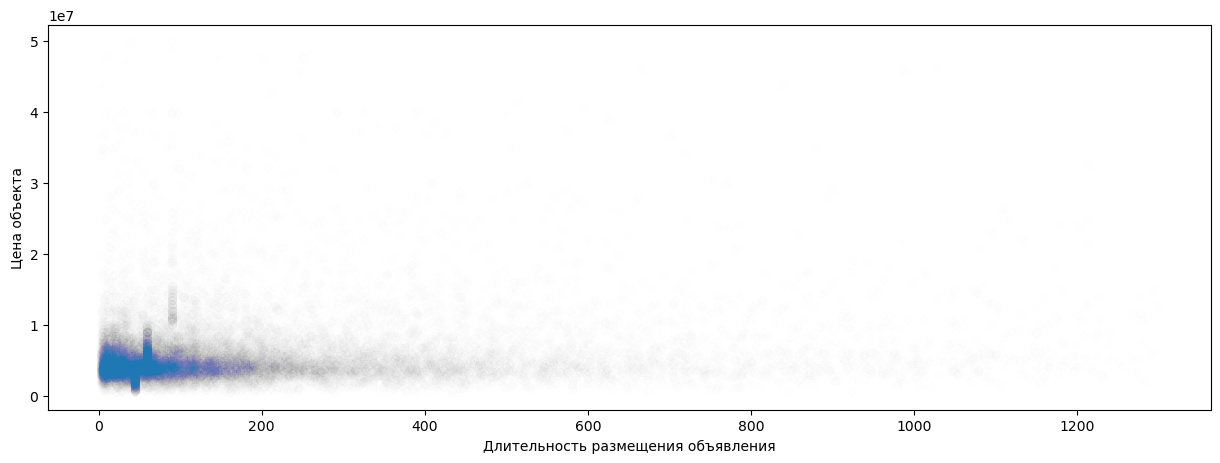

In [190]:
plt.figure(figsize=(15,5))
plt.xlabel('Длительность размещения объявления')
plt.ylabel('Цена объекта')
plt.plot(data['days_exposition'], data['last_price'],'o', alpha=0.003)
plt.show();

На графике видны 3 выделяющихся участка.

Они соответствуют длительности бесплатного размещения объявлений: 
- квартиры до 4,5 млн — 45 дней
- от 4,5 до 10 млн — 60 дней
- от 10 млн — 90 дней

#### **Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

**Общая площадь**

<Axes: xlabel='last_price', ylabel='total_area'>

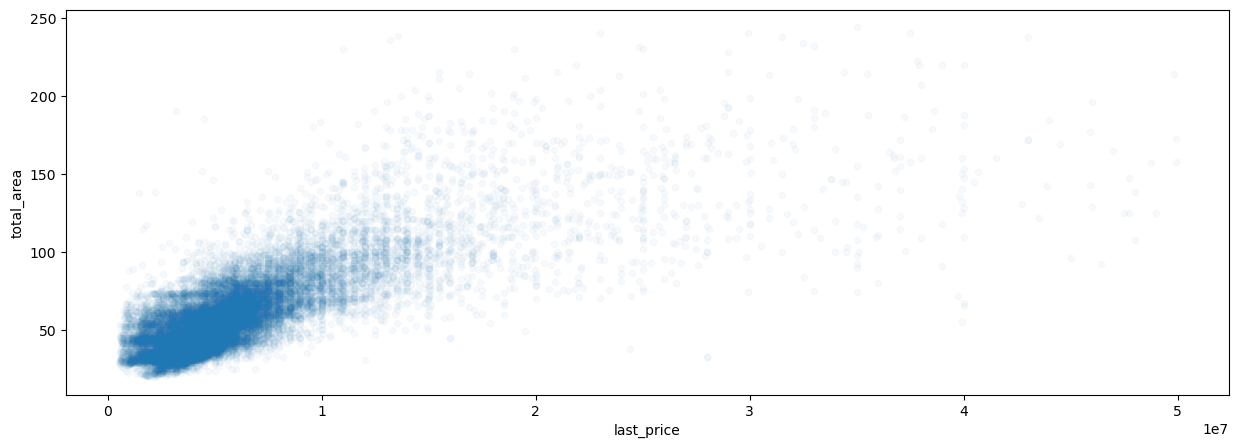

In [191]:
data.plot.scatter(x='last_price',y='total_area',alpha=0.03,figsize=(15,5))

In [192]:
data['last_price'].corr(data['total_area'])

0.7706998058781898

**Жилая площадь**

<Axes: xlabel='last_price', ylabel='living_area'>

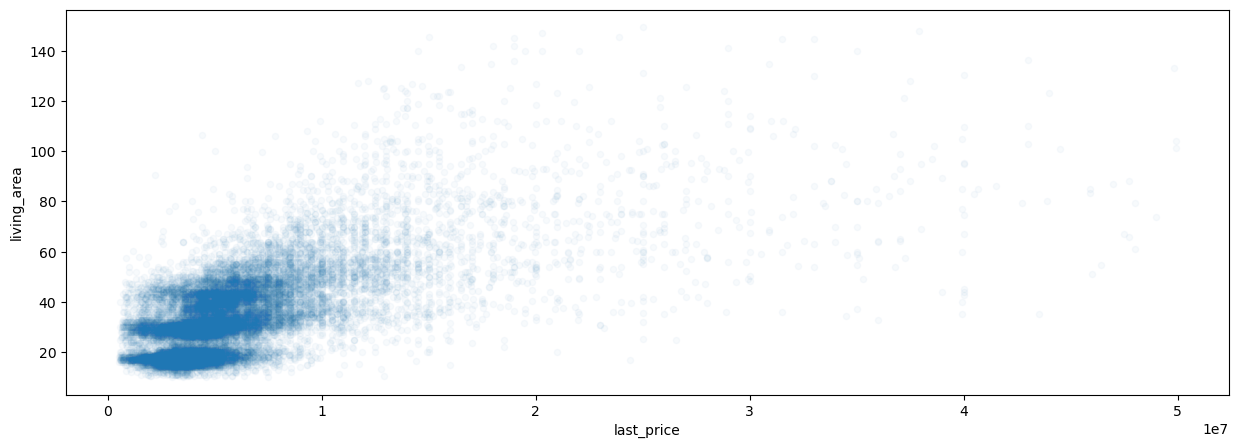

In [193]:
data.plot.scatter(x='last_price',y='living_area',alpha=0.03,figsize=(15,5))

In [194]:
data['last_price'].corr(data['living_area'])

0.6637273134180153

**Площадь кухни**

<Axes: xlabel='last_price', ylabel='kitchen_area'>

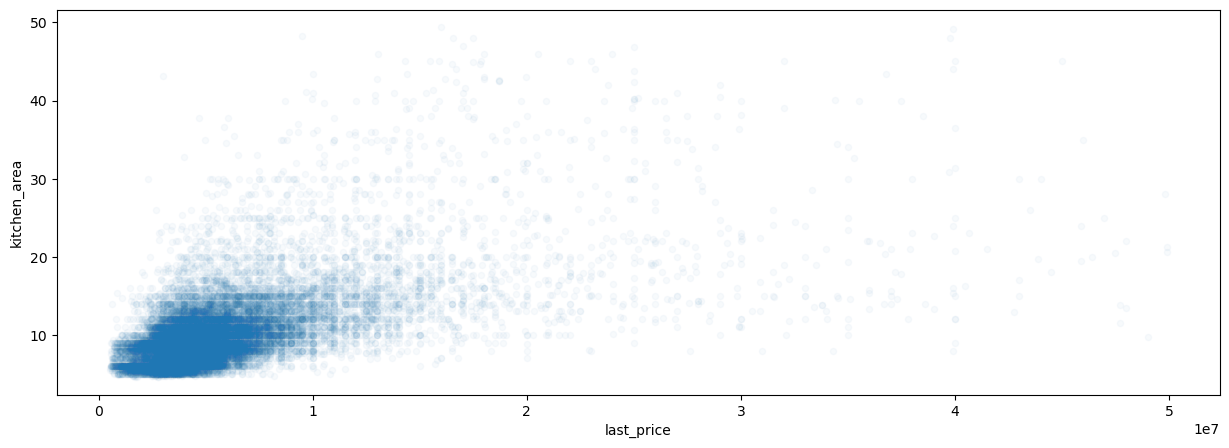

In [195]:
data.plot.scatter(x='last_price',y='kitchen_area',alpha=0.03,figsize=(15,5))

In [196]:
data['last_price'].corr(data['kitchen_area'])

0.5879704219066687

**Количество комнат**

<Axes: xlabel='last_price', ylabel='rooms'>

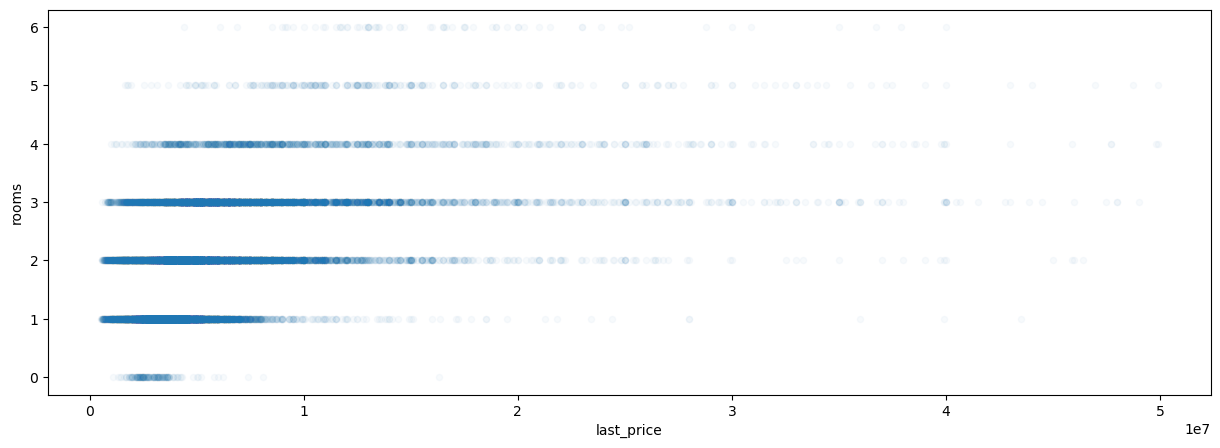

In [197]:
data.plot.scatter(x='last_price',y='rooms',alpha=0.03,figsize=(15,5))

In [198]:
data['last_price'].corr(data['rooms'])

0.4721784020769624

**День размещения объявления**

<Axes: xlabel='last_price', ylabel='exposition_dow'>

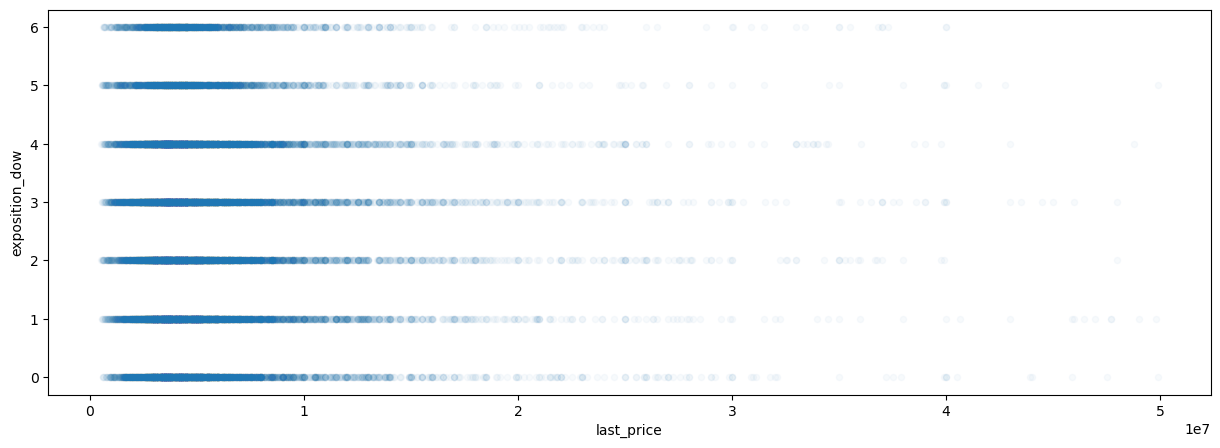

In [199]:
data.plot.scatter(x='last_price',y='exposition_dow',alpha=0.03,figsize=(15,5))

In [200]:
data['last_price'].corr(data['exposition_dow'])

-0.01793922324274666

**Месяц размещения объявления**

<Axes: xlabel='last_price', ylabel='exposition_month'>

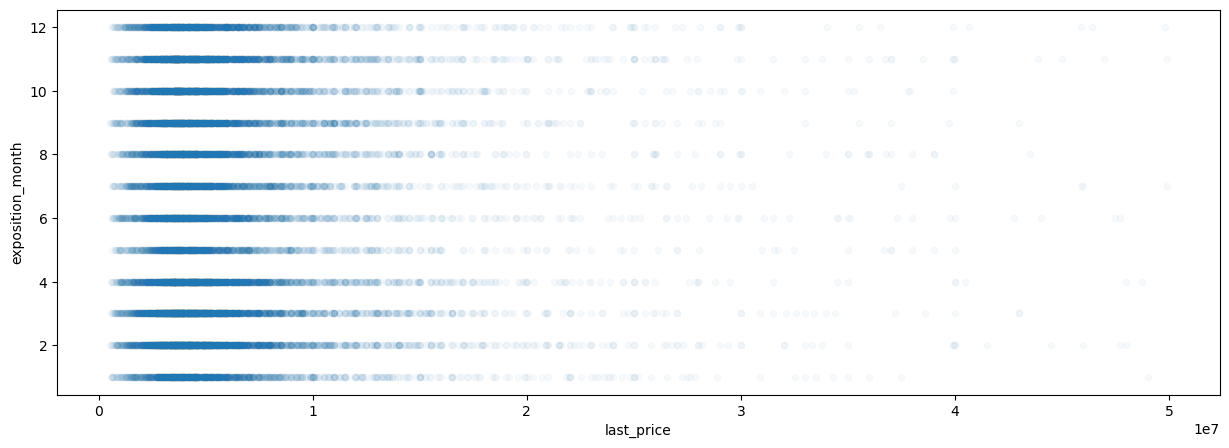

In [201]:
data.plot.scatter(x='last_price',y='exposition_month',alpha=0.03,figsize=(15,5))

In [202]:
data['last_price'].corr(data['exposition_month'])

0.0006839787832210805

**Год размещения объявления**

<Axes: xlabel='last_price', ylabel='exposition_year'>

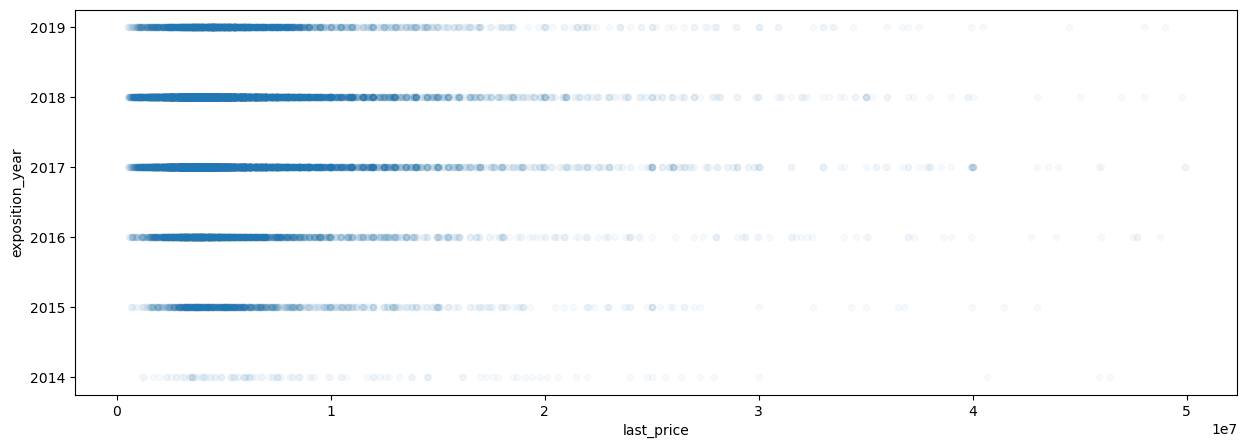

In [203]:
data.plot.scatter(x='last_price',y='exposition_year',alpha=0.03,figsize=(15,5))

In [204]:
data['last_price'].corr(data['exposition_year'])

-0.03663773612344564

**Тип этажа**

<Axes: xlabel='last_price', ylabel='floor_type_int'>

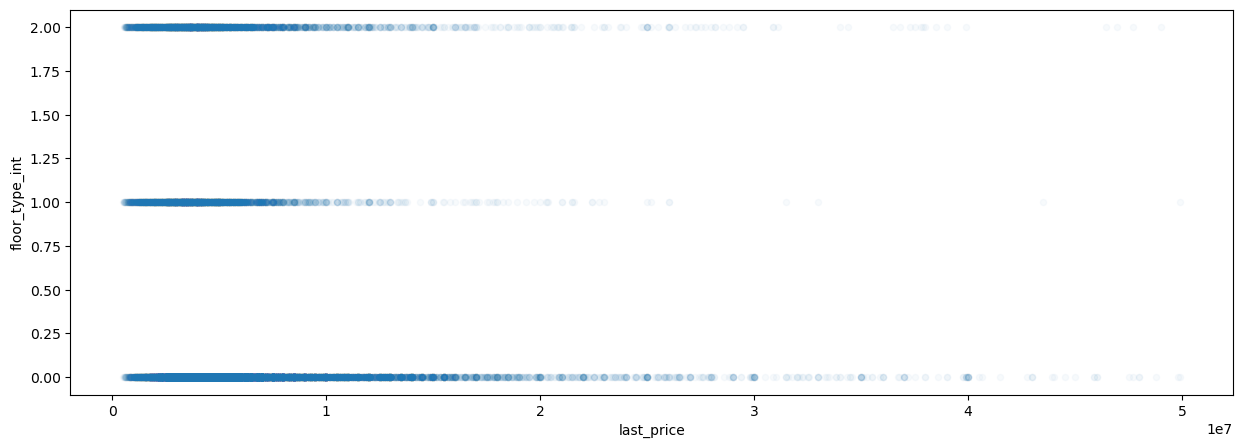

In [205]:
data.plot.scatter(x='last_price',y='floor_type_int',alpha=0.03,figsize=(15,5))

In [206]:
data['last_price'].corr(data['floor_type_int'])

-0.06718088729077037

In [207]:
for year in data['exposition_year'].sort_values().unique():
    print('Всего объявлений в ',end='')
    print(year,end='')
    print(' году :' , data[data['exposition_year']==year]['last_price'].count(),end='')
    print(' Cредняя стоимость : ',end='')
    print(data[data['exposition_year']==year]['last_price'].mean())

Всего объявлений в 2014 году : 115 Cредняя стоимость : 10533772.973913044
Всего объявлений в 2015 году : 1091 Cредняя стоимость : 6805019.477543538
Всего объявлений в 2016 году : 2668 Cредняя стоимость : 5982043.971514243
Всего объявлений в 2017 году : 7867 Cредняя стоимость : 5755880.837167917
Всего объявлений в 2018 году : 8228 Cредняя стоимость : 5647393.110962567
Всего объявлений в 2019 году : 2772 Cредняя стоимость : 6209340.072150072


In [208]:
for year in data['exposition_year'].sort_values().unique():
    print('В ',end='')
    print(year,end='')
    print(' году :', end='')
    print(' Cредняя общая площадь помещения : ',end='')
    print(data[data['exposition_year']==year]['total_area'].mean())

В 2014 году : Cредняя общая площадь помещения : 82.19591304347827
В 2015 году : Cредняя общая площадь помещения : 66.43071494042164
В 2016 году : Cредняя общая площадь помещения : 60.00666416791604
В 2017 году : Cредняя общая площадь помещения : 58.07029998728867
В 2018 году : Cредняя общая площадь помещения : 56.53539742343218
В 2019 году : Cредняя общая площадь помещения : 57.30890692640693


Больше всего на цену влияют такие параметры как общая площадь, жилая площадь и площадь кухни.

Также цена меняется в зависимости от количества комнат.

Остальные параметры - день/месяц/год подачи объявления и этаж, на котором расположено помещение, не влияют на цену.

Наивысщая средняя стоимость наблюдается в 2014 году, но количество объявлений всего 115

Средняя стоимость в 2016 году значительно упала по сравнению с 2015 годом, а в 2019 поднялась

До 2019 года средняя общая площадь незначительно уменьшается, а в 2019 немного возрастает

#### **Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**


In [209]:
list = data['locality_name'].value_counts().head(10)
cubic_prices=pd.DataFrame({
    'name': [],
    'value': []
    })
i=0
for locality in list.index:
    cubic_prices.at[i, 'name']=locality
    cubic_prices.at[i, 'value'] = (data[data['locality_name']==locality]['cubic_meter_price'].sum()/
    data[data['locality_name']==locality]['locality_name'].count())
    i+=1
print('Средняя цена: ', cubic_prices['value'].mean(),'\n')
print('Максимальная и минимальная средняя цена:')
(cubic_prices[(cubic_prices['value']==cubic_prices['value'].min())|(cubic_prices['value']==cubic_prices['value'].max())])

Средняя цена:  83662.19280669832 

Максимальная и минимальная средняя цена:


,name,value
0,Санкт-Петербург,111841.768069
9,Выборг,58619.534209


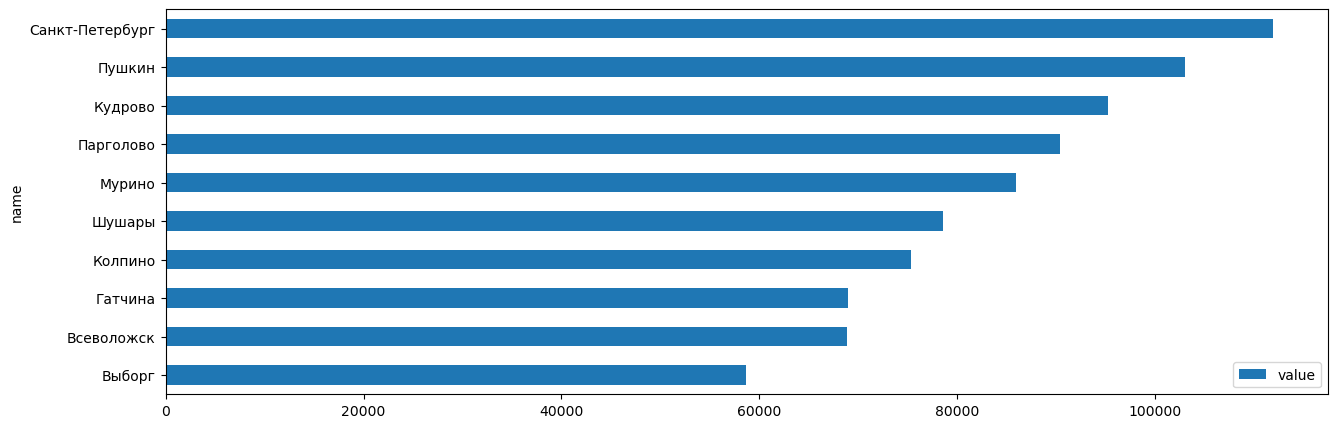

In [210]:
cubic_prices.sort_values(by='value').plot(kind='barh',x='name', figsize=(15,5));

#### **Средняя цена за каждый километр от центра**

Процент от общей средней цены от 10 км до центра: 73.24
Процент от общей средней цены до 10 км до центра: 153.52
Процент от общей средней цены в центре: 236.36


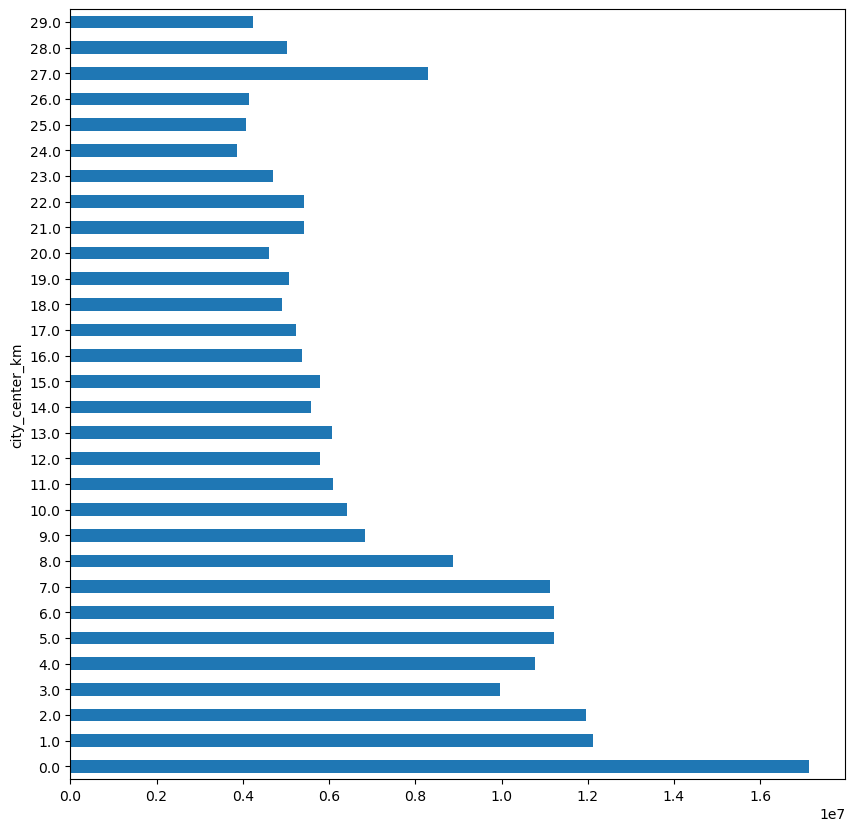

In [211]:
df_spb = data[data['locality_name']=='Санкт-Петербург']
df_spb = df_spb[['last_price','city_center_km']]
df_spb = df_spb.pivot_table(index='city_center_km', values='last_price', aggfunc=['sum', 'count'])
df_spb['mean'] = df_spb['sum']/df_spb['count']
df_spb['mean'].plot(kind='barh', figsize=(10,10))
print('Процент от общей средней цены от 10 км до центра: ''%.2f' % (
    df_spb[df_spb.index>=10]['mean'].mean()/df_spb['mean'].mean()*100))
print('Процент от общей средней цены до 10 км до центра: ''%.2f' % (
    df_spb[df_spb.index<10]['mean'].mean()/df_spb['mean'].mean()*100))
print('Процент от общей средней цены в центре: ''%.2f' % (df_spb[df_spb.index<1]['mean'].mean()/df_spb['mean'].mean()*100))

In [212]:
for i in df_spb.index:
    print('Цена за ',i, 'км от центра составляет :''%.2f' %(df_spb[df_spb.index==i]['mean'].mean()/
                                                            df_spb['mean'].max()*100),end='')
    print('% от максимальной цены в центре города')

Цена за  0.0 км от центра составляет :100.00% от максимальной цены в центре города
Цена за  1.0 км от центра составляет :70.82% от максимальной цены в центре города
Цена за  2.0 км от центра составляет :69.81% от максимальной цены в центре города
Цена за  3.0 км от центра составляет :58.24% от максимальной цены в центре города
Цена за  4.0 км от центра составляет :62.96% от максимальной цены в центре города
Цена за  5.0 км от центра составляет :65.51% от максимальной цены в центре города
Цена за  6.0 км от центра составляет :65.47% от максимальной цены в центре города
Цена за  7.0 км от центра составляет :64.92% от максимальной цены в центре города
Цена за  8.0 км от центра составляет :51.82% от максимальной цены в центре города
Цена за  9.0 км от центра составляет :39.95% от максимальной цены в центре города
Цена за  10.0 км от центра составляет :37.54% от максимальной цены в центре города
Цена за  11.0 км от центра составляет :35.60% от максимальной цены в центре города
Цена за  12.0

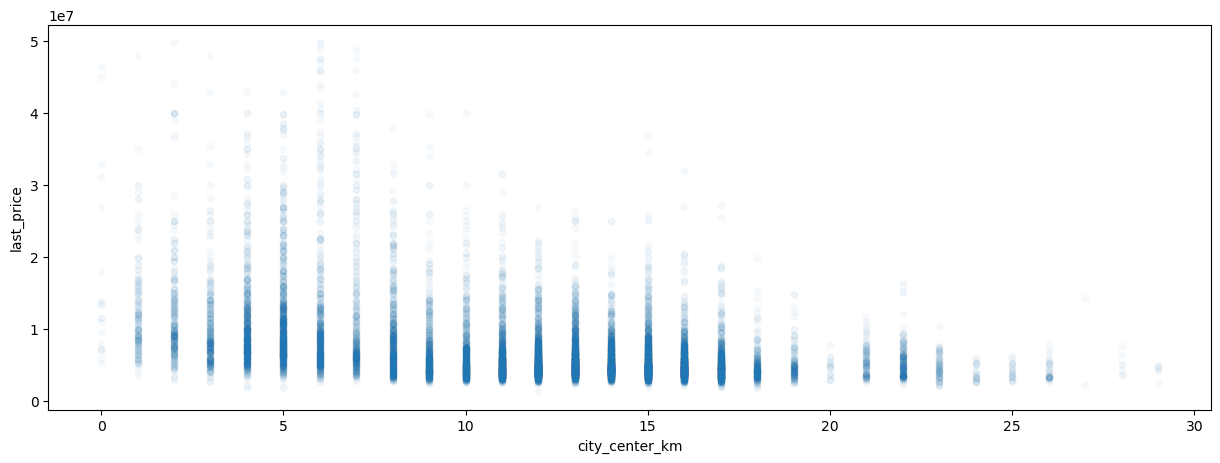

In [213]:
data[data['locality_name']=='Санкт-Петербург'].plot.scatter(x='city_center_km',y='last_price',alpha=0.03,figsize=(15,5));

In [214]:
data[(data['locality_name']=='Санкт-Петербург')&(data['city_center_km']==27)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,ponds_around3000,ponds_nearest,days_exposition,cubic_meter_price,exposition_dow,exposition_month,exposition_year,floor_type,floor_type_int,city_center_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,0.0,NaN,128.0,193918.918919,1,11,2017,Другой,0,27.0
5961,6,2250000.0,32.0,2018-02-27,1,NaN,2,16.5,2,False,...,0.0,NaN,178.0,70312.500000,1,2,2018,Последний,2,27.0


Выброс на 27м километре связан с тем, что в этом значении всего 2 объявления - 2 250т.р. и 14 350т.р.

In [215]:
floor_types_by_km=pd.DataFrame({
    'km': [],
    'Первый': [],
    'Последний': [],
    'Другой': []
    })
i=0
for km in data[(data['locality_name']=='Санкт-Петербург')]['city_center_km'].sort_values().unique():
    floor_types_by_km.at[i,'km']=km
    for floor_type in data['floor_type'].sort_values().unique():
        floor_types_by_km.at[i,floor_type]=data[(data['locality_name']=='Санкт-Петербург')&(data['city_center_km']==km)&(
            data['floor_type']==floor_type)]['floor_type'].count()
    i+=1


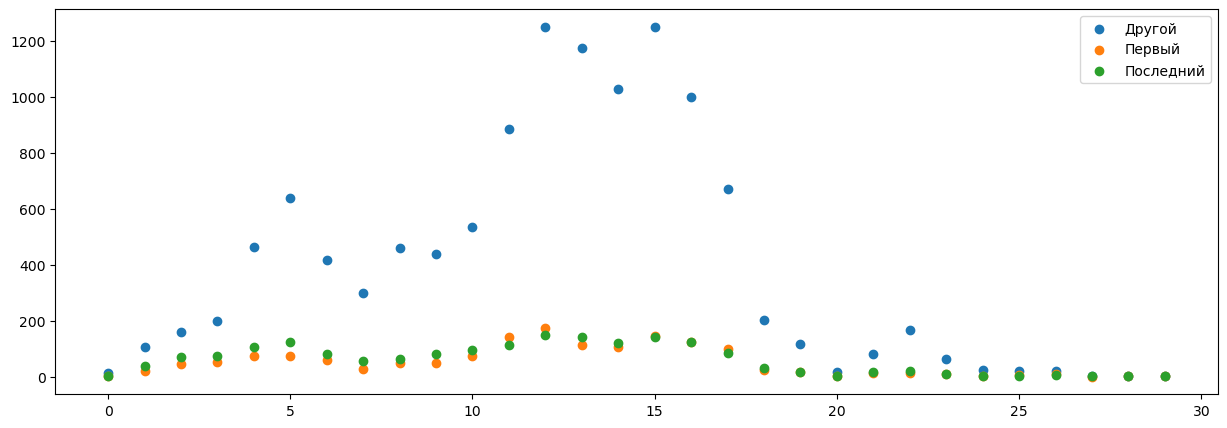

In [216]:
plt.figure(figsize=(15,5))
plt.scatter(x=floor_types_by_km['km'],y=floor_types_by_km['Другой'])
plt.scatter(x=floor_types_by_km['km'],y=floor_types_by_km['Первый'])
plt.scatter(x=floor_types_by_km['km'],y=floor_types_by_km['Последний'])
plt.legend(['Другой', 'Первый', 'Последний'])
plt.show;

### Общий вывод

**Как быстро продавались квартиры?**

Обычно продажа занимает приблизительно **95 дней**. Средняя скорость продажи составляет **177 дней**. Объявления, снятые раньше **45 дней**, можно считать *быстрыми*, а длительностью более **232 дней** - *необычно долгими*.

**Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

Больше всего на цену влияют такие параметры как *общая площадь, жилая площадь и площадь кухни.* Также цена меняется в зависимости от *количества комнат*.

Остальные параметры - день/месяц/год подачи объявления и этаж, на котором расположено помещение, не влияют на цену.

Наивысщая средняя стоимость наблюдается в **2014 году**, но количество объявлений всего **115**.

Средняя стоимость в 2016 году **значительно упала** по сравнению с 2015 годом, а в 2019 поднялась.

До 2019 года средняя общая площадь незначительно уменьшается, а в 2019 немного возрастает.

**Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

*Средняя цена*:  83920.77
Максимальная цена в  *Санкт-Петербурге*  составляет:  114849.01
Минимальная цена в  *Выборге* составляет:  58141.91

**Средняя цена за каждый километр от центра**

Процент от общей средней цены от 10 км до центра: 73.24
Процент от общей средней цены до 10 км до центра: 153.52
Процент от общей средней цены в центре: 236.36

Средние цены помещений *снижаются при удалении от центра* и имеют неочевидные значения.

Помещения в трех километрах от центра имеют среднюю стоимость на *17.89% ниже*, чем помещения в двух и четырех км от центра.

Цена на 27 километре выше своих соседей на *46.11%*



